# COPDgene model 1

Please note, this notebook contains code for the application of PathIntegrate to COPDgene multi-omics data. It can only be run after access to the data has been granted. The COVID application contains publicly available data, which is uploaded to this repository.

In [1]:
import pandas as pd
import numpy as np
import sspa
import sklearn
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from sklearn.model_selection import StratifiedKFold
import patchworklib as pw
from mbpls.mbpls import MBPLS
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, explained_variance_score
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests


c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


<Figure size 100x100 with 0 Axes>

In [2]:
# load metadata
md = pd.read_csv('D:\COPDgene\COPDGene_P1P2_SM_NS_25OCT21.txt', sep='\t')


In [47]:

# load multi-omics pathways
reactome_cpds = sspa.process_gmt('../Pathway_databases/Reactome_Homo_sapiens_pathways_compounds_R81.gmt')
reactome_uniprot = sspa.process_pathways.process_reactome("Homo sapiens", "../Pathway_databases/UniProt2Reactome_All_Levels.txt")
reactome_ensembl = sspa.process_pathways.process_reactome("Homo sapiens", "D:/Pathway_databases/Ensembl2Reactome_All_Levels.txt")


In [4]:

# load omics datasets
prot = pd.read_csv('A:\home\pathway-integration\COPDgene/COPDgene_proteomics_UniProt_scaled.csv', index_col=0)
prot = prot.drop(['23931W',
 '21318W',
 '24385A',
 '19819A',
 '17417W',
 '24265Q',
 '23761X',
 '23504D',
 '17828R',
 '21748V'], axis=0)
metab = pd.read_csv('../COPDgene/COPDgene_metabolomics_CHEBI_mapped.csv', index_col=0)
trans = pd.read_csv('D:/COPDgene/Processed/COPDgene_transcriptomics_filt_Q1_scaled.csv', index_col=0)


In [67]:
mo_paths_all = pd.read_csv('D:/Pathway_databases\Reactome_multi_omics_ChEBI_Uniprot_Ensembl.csv', index_col=0, dtype=object)

In [83]:
md[md['Phase_study'] == 2]['finalGold'].value_counts()

 0.0    2847
 2.0    1265
-1.0     765
 3.0     646
 1.0     540
 4.0     170
-2.0      86
Name: finalGold, dtype: int64

In [4]:
md['finalgold_Phase2'].value_counts()

 0.0    2423
 2.0    1131
-1.0     717
 3.0     590
 1.0     542
-2.0     392
 4.0     249
Name: finalgold_Phase2, dtype: int64

In [7]:
md

sid        cohort ccenter  visitnum  Phase_study  Visit_Year  \
0      10002K        Smoker     C21         1            1        2007   
1      10002K        Smoker     C21         2            2        2014   
2      10004O        Smoker     C21         1            1        2007   
3      10005Q        Smoker     C09         1            1        2008   
4      10005Q        Smoker     C09         2            2        2013   
...       ...           ...     ...       ...          ...         ...   
17017  30949G  Never smoked     C16         2            2        2017   
17018  30950R  Never smoked     C16         2            2        2017   
17019  30951T  Never smoked     C16         2            2        2017   
17020  30952V  Never smoked     C16         2            2        2017   
17021  30953X  Never smoked     C16         2            2        2017   

       days_since_baseline  years_from_baseline  gender  race  ...  \
0                        0             0.000000       2     1  ...   
1                     2600             7.118412       2     1  ...   
2                        0             0.000000       1     1  ...   
3                        0             0.000000       2     1  ...   
4                     2009             5.500342       2     1  ...   
...                    ...                  ...     ...   ...  ...   
17017                    0             0.000000       1     1  ...   
17018                    0             0.000000       1     1  ...   
17019                    0             0.000000       1     1  ...   
17020                    0             0.000000       1     1  ...   
17021                    0             0.000000       2     1  ...   

       UpperThird_LowerThird_Slicer  TLC_CT  FRC_CT    pctEmph  pctGasTrap  \
0                               NaN     NaN     NaN        NaN         NaN   
1                               NaN     NaN     NaN        NaN         NaN   
2                               NaN  6.4574     NaN  21.363100         NaN   
3                               NaN  5.6636  2.4766   0.926851     6.80077   
4                               NaN  6.1481  3.4466   1.771530    13.67870   
...                             ...     ...     ...        ...         ...   
17017                           NaN  8.2437  5.0373   1.424960    23.32910   
17018                           NaN  4.5835  2.6343   0.881896    17.39480   
17019                           NaN  6.5449  4.6010   2.703620    44.19840   
17020                           NaN  6.5568  3.4676   0.863571     8.56715   
17021                           NaN  4.4720     NaN   0.207480         NaN   

       FRC_TLC_ratio  perc15_insp_thirona  perc15_exp_thirona  \
0                NaN                  NaN                 NaN   
1                NaN                  NaN                 NaN   
2                NaN               -961.0                 NaN   
3              0.437               -906.0              -813.0   
4              0.561               -922.0              -852.0   
...              ...                  ...                 ...   
17017          0.611               -922.0              -875.0   
17018          0.575               -912.0              -863.0   
17019          0.703               -928.0              -905.0   
17020          0.529               -914.0              -836.0   
17021            NaN               -908.0                 NaN   

      meanatten_insp_thirona meanatten_exp_thirona  
0                        NaN                   NaN  
1                        NaN                   NaN  
2                   -869.566                   NaN  
3                   -830.343              -650.526  
4                   -851.516              -732.794  
...                      ...                   ...  
17017               -852.386              -756.218  
17018               -822.164              -706.768  
17019               -855.304              -801.127  
17020               -829.582    

In [ ]:
# Filter by GOLD score
md = md[md['cohort'] == 'Smoker']
md = md[md['finalgold_Phase2'] > -1]
md['finalGoldP2_binary'] = md['finalgold_Phase2'].map({0:0, 1:1, 2:1, 3:1, 4:1})

metab['Group'] = metab.index.map(dict(zip(md['sid'], md['finalGoldP2_binary'])))
metab = metab[metab['Group'].isin([0, 1])]
intersect_samples = set(metab.index.tolist()) & set(prot.index.tolist()) & set(trans.index.tolist())
prot = prot.loc[intersect_samples, :]
metab = metab.loc[intersect_samples, :]
trans = trans.loc[intersect_samples, :]

Look at metadata variables on subcohort with 3 omics

In [ ]:
md['FVC']

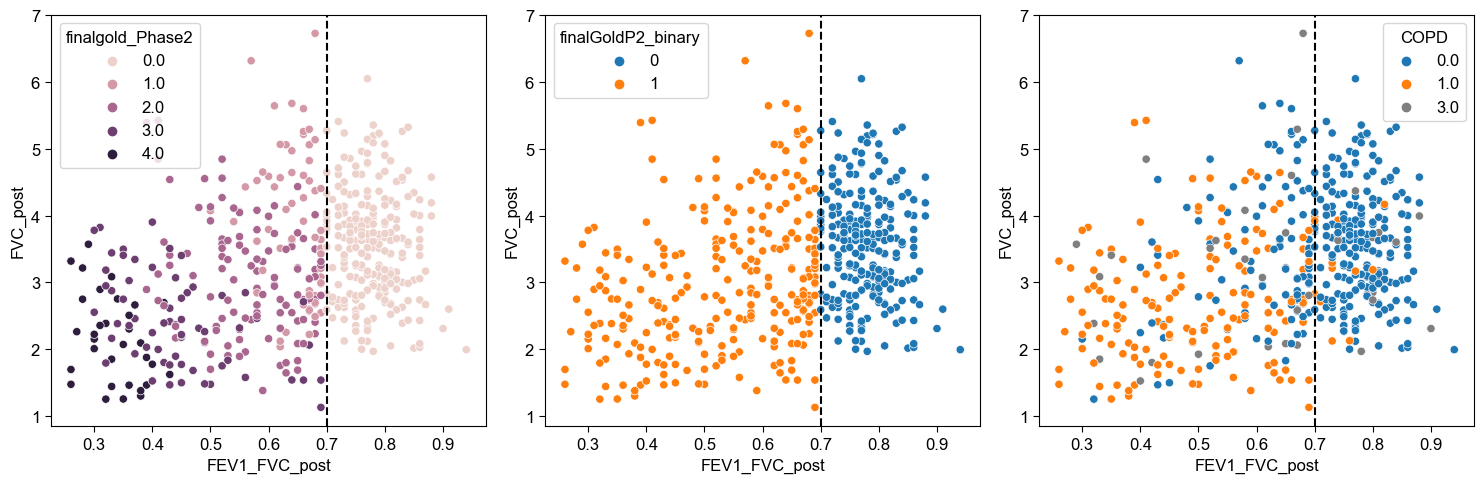

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(
    y=md[md['sid'].isin(metab.index)]['FVC_post'],
    x=md[md['sid'].isin(metab.index)]['FEV1_FVC_post'],
    hue=md[md['sid'].isin(metab.index)]['finalgold_Phase2'],
    ax=ax1
)
sns.scatterplot(
    y=md[md['sid'].isin(metab.index)]['FVC_post'],
    x=md[md['sid'].isin(metab.index)]['FEV1_FVC_post'],
    hue=md[md['sid'].isin(metab.index)]['finalGoldP2_binary'],
    ax=ax2
)
sns.scatterplot(
    y=md[md['sid'].isin(metab.index)]['FVC_post'],
    x=md[md['sid'].isin(metab.index)]['FEV1_FVC_post'],
    hue=md[md['sid'].isin(metab.index)]['COPD'],
    palette={0:'tab:blue', 1:'tab:orange', 3:'tab:grey'},
    ax=ax3
)

ax1.axvline(0.7, color='black', linestyle='--')
ax2.axvline(0.7, color='black', linestyle='--')
ax3.axvline(0.7, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [24]:
metab['Group'].isna().sum() 

0

In [20]:
md[md['sid'].isin(metab.index)].cohort.value_counts()

Smoker    522
Name: cohort, dtype: int64

In [13]:
prot_scaled['Group'].value_counts()

1    273
0    249
Name: Group, dtype: int64

In [25]:
trans_scaled['Group'].value_counts()

1    273
0    249
Name: Group, dtype: int64

In [6]:
# rescale all datasets
metab_scaled = pd.DataFrame(StandardScaler().fit_transform(metab), columns=metab.columns, index=metab.index)
prot_scaled = pd.DataFrame(StandardScaler().fit_transform(prot), columns=prot.columns, index=prot.index)
trans_scaled = pd.DataFrame(StandardScaler().fit_transform(trans), columns=trans.columns, index=trans.index)
metab_scaled['Group'] = metab_scaled.index.map(dict(zip(md['sid'], md["finalGoldP2_binary"])))
prot_scaled['Group'] = prot_scaled.index.map(dict(zip(md['sid'], md["finalGoldP2_binary"])))
trans_scaled['Group'] = trans_scaled.index.map(dict(zip(md['sid'], md["finalGoldP2_binary"])))

In [85]:
metab.shape

(522, 513)

In [86]:
prot.shape

(522, 1305)

In [87]:
trans.shape

(522, 14441)

In [23]:
metab_pca = PCA(5)
metab_pca_df = pd.DataFrame(metab_pca.fit_transform(metab_scaled.iloc[:, :-1]))
metab_pca_df['Group'] = metab['Group'].values

In [24]:
metab_pca.explained_variance_ratio_

array([0.08388926, 0.05990931, 0.04329322, 0.03676953, 0.02746587])

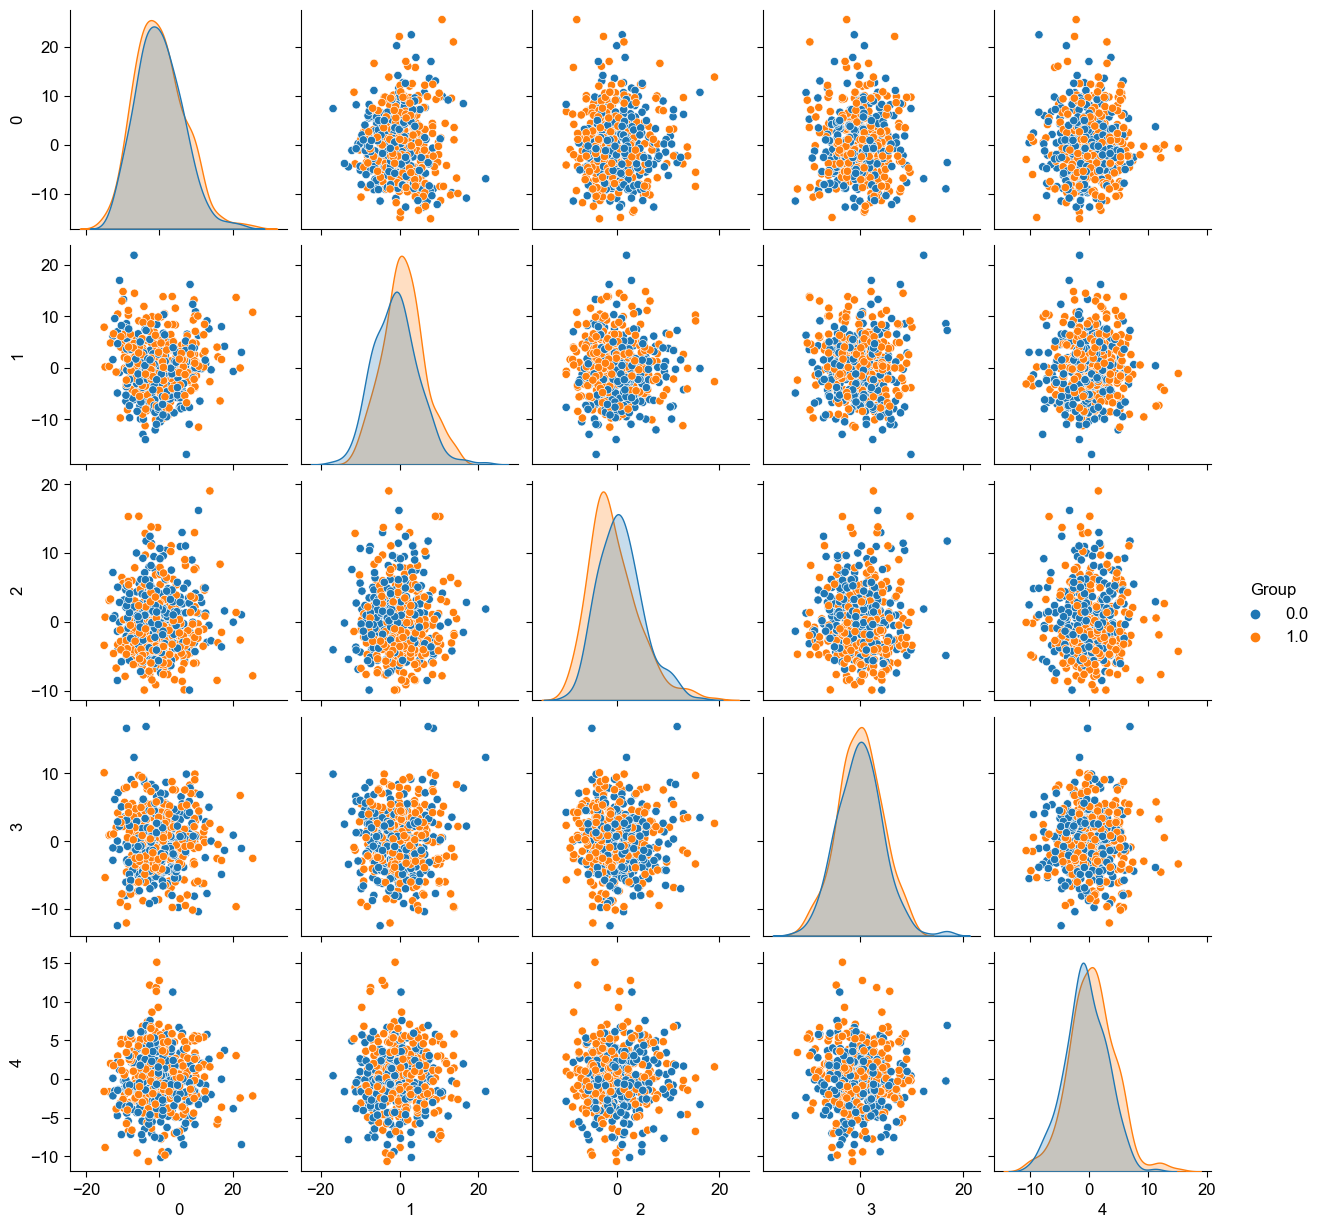

In [25]:
sns.pairplot(metab_pca_df, hue='Group')

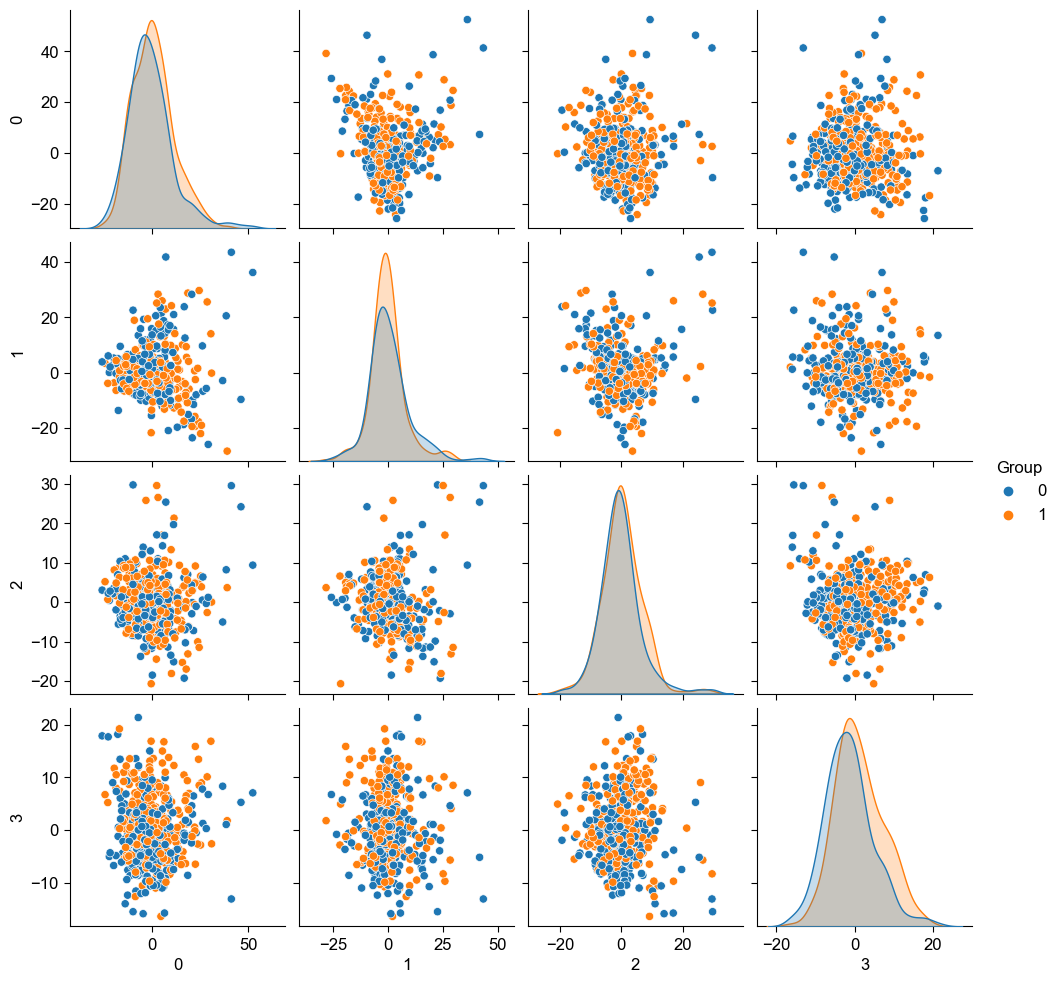

In [27]:
prot_pca = PCA(4)
prot_pca_df = pd.DataFrame(prot_pca.fit_transform(prot_scaled.iloc[:, :-1]), index=prot_scaled.index)
prot_pca_df['Group'] = prot_scaled['Group'].values
sns.pairplot(prot_pca_df, hue='Group')

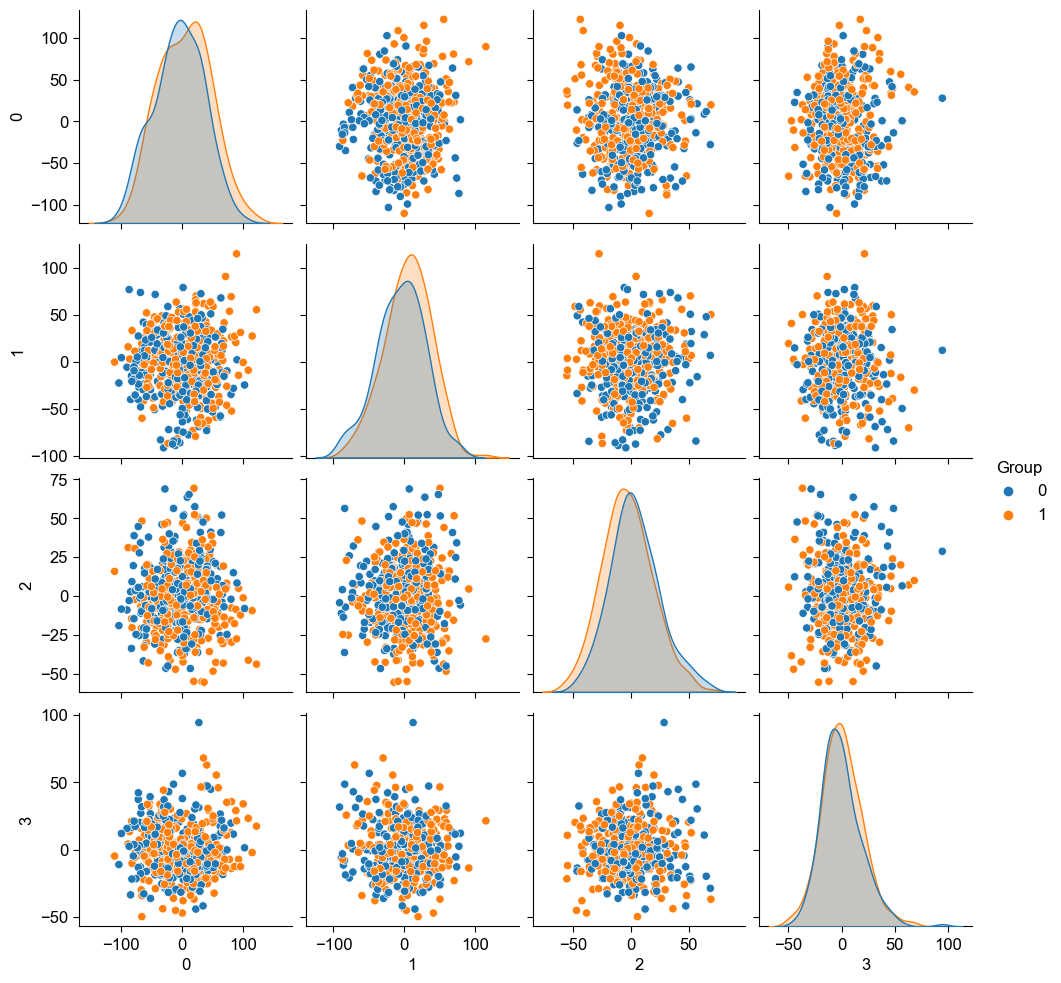

In [28]:
trans_pca = PCA(4)
trans_pca_df = pd.DataFrame(trans_pca.fit_transform(trans_scaled.iloc[:, :-1]))
trans_pca_df['Group'] = prot_scaled['Group'].values
sns.pairplot(trans_pca_df, hue='Group')

In [41]:
kpca_scores_met = pd.read_csv('../COPDgene/KPCA_Met_Scores.csv', index_col=0)
kpca_scores_prot = pd.read_csv('../COPDgene/KPCA_Prot_Scores.csv', index_col=0)
kpca_scores_trans = pd.read_csv('../COPDgene/KPCA_Trans_Scores.csv', index_col=0)

In [6]:
mo_paths = pd.read_csv("../Pathway_databases/Reactome_multi_omics_ChEBI_Uniprot.csv", index_col=0)

## 3 Omics model - PathIntegrate MultiView

In [48]:
# kpca_scores_met = sspa.sspa_kpca(metab_scaled, reactome_cpds)
# kpca_scores_prot = sspa.sspa_kpca(prot_scaled, reactome_uniprot)
# kpca_scores_trans = sspa.sspa_kpca(trans_scaled, reactome_ensembl)

kpca_scores_met = sspa.sspa_KPCA(reactome_cpds).fit_transform(metab_scaled.iloc[:, :-1])
kpca_scores_prot = sspa.sspa_KPCA(reactome_uniprot).fit_transform(prot_scaled.iloc[:, :-1])
kpca_scores_trans = sspa.sspa_KPCA(reactome_ensembl).fit_transform(trans_scaled.iloc[:, :-1])

In [49]:
kpca_scores_met.shape

(522, 202)

In [50]:
kpca_scores_prot.shape

(522, 1396)

In [51]:
kpca_scores_trans.shape

(522, 1902)

In [52]:
kpca_scores_met.to_csv('D:/COPDgene/KPCA_Met_Scores_GOLD.csv')
kpca_scores_prot.to_csv('D:/COPDgene/KPCA_Prot_Scores_GOLD.csv')
kpca_scores_trans.to_csv('D:/COPDgene/KPCA_Prot_Scores_GOLD.csv')

In [45]:
kpca_scores_met = pd.read_csv('D:/COPDgene/KPCA_Met_Scores_GOLD.csv', index_col=0)
kpca_scores_prot = pd.read_csv('D:/COPDgene/KPCA_Prot_Scores_GOLD.csv', index_col=0)
kpca_scores_trans = pd.read_csv('D:/COPDgene/KPCA_Prot_Scores_GOLD.csv', index_col=0)

In [53]:
labels = kpca_scores_met.index.map(dict(zip(md['sid'], md["finalGoldP2_binary"])))
# labels = pd.factorize(metab_scaled['Group'])[0]

In [46]:
kpca_scores_prot

R-HSA-1059683  R-HSA-109581  R-HSA-109582  R-HSA-109606  R-HSA-109704  \
14838F       0.464849      0.212159     -0.249448      0.356272      0.501585   
11468J      -0.256721     -0.241722      0.118083     -0.175225     -0.328796   
23870C       0.454542      0.433323     -0.331432      0.255770      0.562828   
15118C      -0.355287     -0.292411      0.331554     -0.288483     -0.376229   
22052P      -0.252558     -0.192766      0.131851     -0.191732     -0.367719   
...               ...           ...           ...           ...           ...   
22545M       0.086766     -0.105711      0.191155     -0.075606      0.056430   
15123V      -0.389937     -0.130594      0.091016     -0.132566     -0.548127   
10512H       0.010832     -0.149766     -0.075004     -0.002690      0.014258   
12778D      -0.366102      0.180325      0.028591      0.165101      0.025992   
18177H      -0.108440     -0.208349      0.303135     -0.196305     -0.162269   

        R-HSA-110056  R-HSA-110312  R-HSA-110313  R-HSA-110314  R-HSA-110320  \
14838F      0.472850      0.508215      0.299989      0.226983      0.483739   
11468J      0.042772      0.104047     -0.090518     -0.134463      0.077944   
23870C      0.134499      0.430874      0.429744      0.464119      0.449968   
15118C     -0.400879     -0.439295     -0.338675     -0.276518     -0.453829   
22052P      0.107746     -0.068222     -0.048491     -0.204081     -0.119491   
...              ...           ...           ...           ...           ...   
22545M     -0.023752     -0.289557     -0.178792     -0.182459     -0.253466   
15123V     -0.244704      0.121275     -0.053195     -0.082189      0.092636   
10512H      0.518077      0.206213      0.080911      0.034095      0.179242   
12778D      0.158291      0.401969      0.417856      0.455383      0.413540   
18177H     -0.319375     -0.305470     -0.244524     -0.297955     -0.332889   

        ...  R-HSA-983168  R-HSA-983169  R-HSA-983170  R-HSA-983189  \
14838F  ...      0.300609      0.297885      0.087059      0.370369   
11468J  ...     -0.102418     -0.103728     -0.053301     -0.020930   
23870C  ...      0.397081      0.373008      0.320495      0.234858   
15118C  ...     -0.286696     -0.301895     -0.445867     -0.360801   
22052P  ...     -0.199876     -0.204616      0.282553     -0.218773   
...     ...           ...           ...           ...           ...   
22545M  ...     -0.168820     -0.166756     -0.155592     -0.288888   
15123V  ...     -0.165071     -0.193315     -0.364756      0.012914   
10512H  ...      0.005429      0.038261      0.313647      0.178671   
12778D  ...      0.041704      0.035985     -0.554838     -0.031821   
18177H  ...     -0.228572     -0.242145     -0.540557     -0.229024   

        R-HSA-983231  R-HSA-983695  R-HSA-983705  R-HSA-983712  R-HSA-991365  \
14838F      0.323026     -0.332288      0.354204      0.234839      0.214481   
11468J     -0.128407      0.368661     -0.285318     -0.168951      0.051128   
23870C      0.332734     -0.467226      0.467267      0.310834      0.131820   
15118C     -0.343286     -0.294390      0.114043     -0.346165     -0.326521   
22052P     -0.165239      0.192473     -0.196683     -0.107968     -0.281789   
...              ...           ...           ...           ...           ...   
22545M     -0.190685      0.412416     -0.298263     -0.177843     -0.136388   
15123V     -0.110303     -0.154892      0.041829     -0.093323     -0.274475   
10512H      0.079471     -0.348591      0.269729     -0.015951      0.082365   
12778D     -0.027220      0.437152     -0.305366     -0.021064     -0.272811   
18177H     -0.298296     -0.069912     -0.021327     -0.222158     -0.318563   

        R-HSA-997272  
14838F      0.462273  
11468J      0.235179  
23870C      0.165589  
15118C     -0.298682  
22052P     -0.447182  
...              ...  
22545M     -0.137503  
15123V     -0.290991  
10512H      0.134392  
12778D     -0.368298  
18177H 

In [10]:
kpca_scores_met

R-HSA-109582  R-HSA-110329  R-HSA-110331  R-HSA-112310  R-HSA-112315  \
sid                                                                            
14838F      0.469818     -0.268716      0.319148     -0.427774     -0.427774   
11468J      0.486008      0.534259      0.458435      0.398601      0.398601   
23870C     -0.429568     -0.096304     -0.423959     -0.098229     -0.098229   
15118C     -0.279340     -0.437821      0.297665     -0.236145     -0.236145   
22052P     -0.267103     -0.024036     -0.356440     -0.052234     -0.052234   
...              ...           ...           ...           ...           ...   
22545M      0.105195      0.647810     -0.324845     -0.110195     -0.110195   
15123V     -0.376994      0.649497      0.461844     -0.139464     -0.139464   
10512H      0.565996      0.587633      0.122614      0.567770      0.567770   
12778D     -0.378849     -0.311902     -0.225764     -0.478558     -0.478558   
18177H     -0.570504     -0.141629      0.287781     -0.400663     -0.400663   

        R-HSA-112316  R-HSA-1237112  R-HSA-1266738  R-HSA-1428517  \
sid                                                                 
14838F     -0.427774      -0.095111       0.606939       0.065009   
11468J      0.398601      -0.203178       0.437348       0.146083   
23870C     -0.098229      -0.605335       0.033961      -0.056075   
15118C     -0.236145       0.430823      -0.591731       0.097927   
22052P     -0.052234       0.094399      -0.006690       0.029473   
...              ...            ...            ...            ...   
22545M     -0.110195      -0.550528       0.289001      -0.583721   
15123V     -0.139464      -0.030163      -0.345263       0.437986   
10512H      0.567770       0.147600       0.671800       0.134887   
12778D     -0.478558      -0.271978      -0.311488       0.494120   
18177H     -0.400663       0.291025      -0.606225       0.115239   

        R-HSA-1430728  ...  R-HSA-9707616  R-HSA-9709957  R-HSA-9717189  \
sid                    ...                                                
14838F       0.165077  ...       0.606939      -0.045300      -0.205277   
11468J       0.058331  ...       0.437348       0.157169      -0.353048   
23870C      -0.214764  ...       0.033961       0.335692       0.534369   
15118C      -0.235834  ...      -0.591731       0.202245       0.307671   
22052P      -0.027576  ...      -0.006690      -0.253005       0.142095   
...               ...  ...            ...            ...            ...   
22545M       0.112293  ...       0.289001      -0.238166       0.342123   
15123V       0.209236  ...      -0.345263       0.236319      -0.115226   
10512H      -0.118684  ...       0.671800      -0.295179      -0.240086   
12778D       0.253897  ...      -0.311488       0.001210       0.072986   
18177H       0.225472  ...      -0.606225       0.281486       0.350143   

        R-HSA-9717207  R-HSA-9734207  R-HSA-9735804  R-HSA-9748784  \
sid                                                                  
14838F      -0.126759       0.319148      -0.408348      -0.020563   
11468J      -0.420843       0.458435      -0.493215      -0.362506   
23870C       0.565137      -0.423959      -0.097215      -0.130832   
15118C       0.294785       0.297665       0.323375       0.463484   
22052P       0.268214      -0.356440       0.586786       0.121703   
...               ...            ...            ...            ...   
22545M       0.428024      -0.324845      -0.155477       0.156979   
15123V      -0.149019       0.461844      -0.454305       0.337423   
10512H      -0.210442       0.122614       0.305374       0.132751   
12778D       0.104364      -0.225764       0.374071       0.191772   
18177H       0.339797       0.287781      -0.163364      -0.127178   

        R-HSA-9749641  R-HSA-975634  R-HSA-9772573  
sid                                                 
14838F       0.074958      0.531889      -0.506328  
11468J      -0.384979  

Fit model

In [54]:
m1_3o = MBPLS(n_components=4)
m1_3o.fit([
    kpca_scores_met,
    kpca_scores_prot,
    kpca_scores_trans
    ],
    labels)

MBPLS(n_components=4)

Compute VIP

In [56]:
def VIP_multiBlock(x_weights, x_superscores, x_loadings, y_loadings):
    # stack the weights from all blocks 
    weights = np.vstack(x_weights)
    # calculate product of sum of squares of superscores and y loadings
    sumsquares = np.sum(x_superscores**2, axis=0) * np.sum(y_loadings**2, axis=0)
    # p = number of variables - stack the loadings from all blocks
    p = np.vstack(x_loadings).shape[0]
    
    # VIP is a weighted sum of squares of PLS weights 
    vip_scores = np.sqrt(p * np.sum(sumsquares*(weights**2), axis=1) / np.sum(sumsquares))
    return vip_scores

In [57]:
variable_importance = VIP_multiBlock(m1_3o.W_, m1_3o.Ts_, m1_3o.P_, m1_3o.V_)

In [39]:
variable_importance

array([2.79780098, 5.72495392, 3.92706851, ..., 0.84996387, 1.43316847,
       1.52838625])

In [40]:
len(variable_importance)

4006

In [72]:
m1_3o.explained_var_y_

[0.07094041224368276,
 0.06132424760167092,
 0.07255590880382189,
 0.08509507206095514]

In [73]:
pd.DataFrame(variable_importance).to_csv('A:/home/pathway-integration/COPDgene/COPD_3O_GOLD_obs_VIP.csv')

In [188]:
vip = VIP_multiBlock(m1_3o.W_, m1_3o.Ts_, m1_3o.P_, m1_3o.V_)

In [189]:
len(vip)

3500

In [190]:
pd.DataFrame(vip).to_csv('A:/home/pathway-integration/COPDgene/COPD_3O_obs_VIP.csv')

<AxesSubplot:ylabel='Count'>

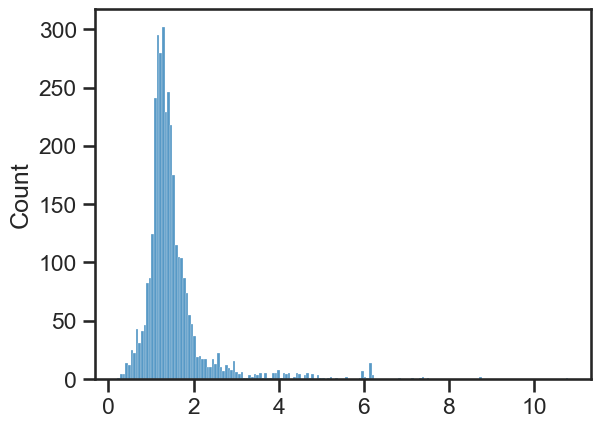

In [191]:
sns.histplot(vip)

In [32]:
m1_3o_m = MBPLS(n_components=4)
m1_3o_m.fit([
    metab.iloc[:, :-1],
    prot.iloc[:, :-1],
    trans.iloc[:, :-1]
    ],
    labels)
m1_3o_m.r2_score([
    metab.iloc[:, :-1],
    prot.iloc[:, :-1],
    trans.iloc[:, :-1]
    ],
    labels)

0.6469780892834054

In [136]:
m1_3o.A_corrected_

array([[0.1526485 , 0.0875563 , 0.11691825, 0.06282794],
       [0.30581086, 0.16602921, 0.43496763, 0.79011452],
       [0.54154064, 0.7464145 , 0.44811412, 0.14705754]])

In [182]:
m1_3o.W_[2].shape

(1902, 4)

In [9]:
m1_3o.A_corrected_.sum(axis=0)

array([1., 1., 1., 1.])

In [46]:
m1_3o.explained_var_xblocks_

array([[0.0377509 , 0.02258108, 0.0111563 , 0.01867114, 0.01255933],
       [0.05882366, 0.05118252, 0.21298336, 0.0824459 , 0.00383851],
       [0.27531663, 0.27658424, 0.0225653 , 0.04474987, 0.03398165]])

In [45]:
m1_3o.explained_var_xblocks_.sum(axis=0)

array([0.37189119, 0.35034784, 0.24670496, 0.14586691, 0.0503795 ])

In [44]:
m1_3o.explained_var_x_

[0.17525592703996234,
 0.17202154589503607,
 0.09785643983818487,
 0.0582800862190986,
 0.0207224730289687]

In [54]:
m1_3o.explained_var_y_

[0.07094041224368276,
 0.06132424760167092,
 0.07255590880382189,
 0.08509507206095514,
 0.11930040701931979]

## Block importance

In [51]:
bip_df = pd.DataFrame(m1_3o.A_corrected_*100)
bip_df = bip_df[[4, 3, 2, 0, 1]]

In [63]:
bip_df

4          3          2          0          1
0  17.081271   5.198081   6.656413  18.723144   5.955618
1  28.286749  68.205899  60.932725  38.640835  19.263190
2  54.631980  26.596019  32.410862  42.636021  74.781192

In [64]:
m1_3o.A_corrected_

array([[0.18723144, 0.05955618, 0.06656413, 0.05198081, 0.17081271],
       [0.38640835, 0.1926319 , 0.60932725, 0.68205899, 0.28286749],
       [0.42636021, 0.74781192, 0.32410862, 0.26596019, 0.5463198 ]])

In [61]:
sorted(m1_3o.explained_var_y_, reverse=True)

[0.11930040701931979,
 0.08509507206095514,
 0.07255590880382189,
 0.07094041224368276,
 0.06132424760167092]

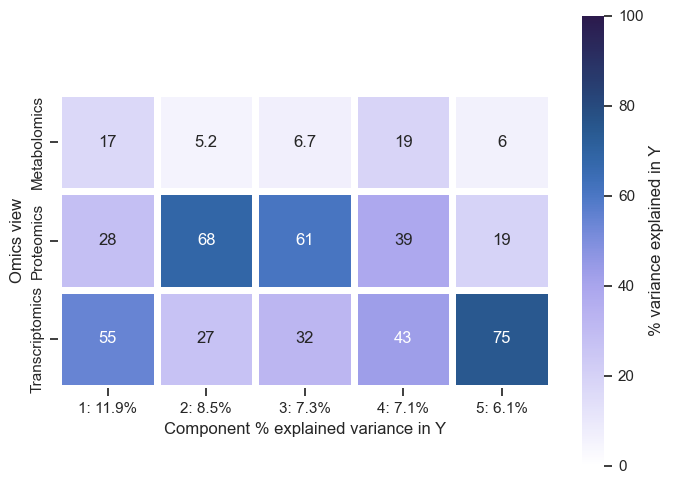

In [65]:
sns.set_context('notebook')
sns.set_style('ticks')
plt.figure(figsize=(7, 5))
sns.heatmap(bip_df, cmap='cmc.devon_r', linewidth=5, square=True,
 cbar_kws={'label': '% variance explained in Y'},
 annot=True,
 vmin=0,
 vmax=100)
plt.yticks([0.5, 1.5, 2.5], ['Metabolomics', 'Proteomics', 'Transcriptomics'])
plt.xticks([i+0.5 for i in range(0, 5)], [str(n+1) + ': ' + str(np.around(i*100, 1))+'%' for n, i in enumerate(sorted(m1_3o.explained_var_y_, reverse=True))])
# plt.xticks([i+0.5 for i in range(0, 5)], range(1, 6))
plt.xlabel('Component % explained variance in Y')
plt.ylabel('Omics view')
plt.tight_layout()
plt.savefig('../Figures/MBPLS_COPD_Model1_3o_block_importance_GOLD.png', dpi=300)
plt.show()

In [194]:
m1_3o.explained_var_y_

[0.06900325281525851,
 0.062178802145136325,
 0.07258522535634734,
 0.08558736188194116]

In [141]:
m1_3o.beta_

array([[-6.94948914e-04],
       [ 7.30920006e-04],
       [ 3.32000659e-03],
       ...,
       [-5.34161413e-08],
       [-7.02312771e-04],
       [ 4.31493354e-04]])

## Superscores plot

In [175]:
sum(m1_3o.explained_var_y_)

0.40788335665951914

In [74]:
m1_3o.explained_var_y_

[0.07094041224368276,
 0.06132424760167092,
 0.07255590880382189,
 0.08509507206095514]

In [75]:
# ordered_lv = [4, 3, 2, 0, 1]
ordered_lv = [ 3, 2, 0,1]
super_scores = pd.DataFrame(m1_3o.Ts_, columns=range(1, 5), index=kpca_scores_met.index)
super_scores = super_scores.iloc[:, ordered_lv]
super_scores.columns = range(1, 5)


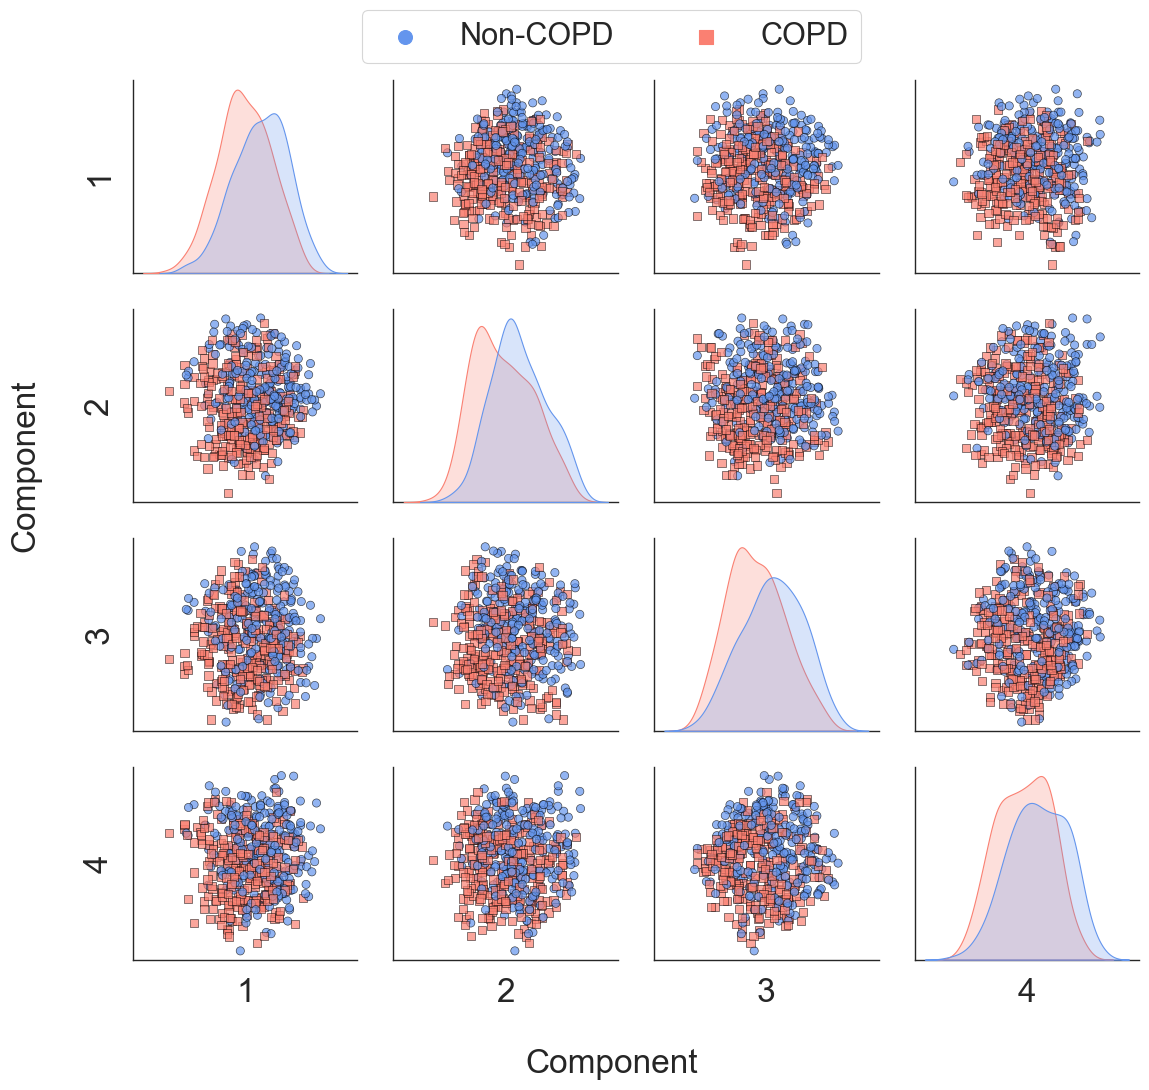

In [77]:
# with sns.plotting_context("paper", font_scale=2.1):
sns.set_context('paper', font_scale=2.5)
sns.set_style('white')

super_scores['Group'] = super_scores.index.map(dict(zip(md['sid'], md["finalGoldP2_binary"])))
g = sns.pairplot(super_scores, hue='Group', palette=['cornflowerblue', 'salmon'], plot_kws={"s":35, 'alpha':0.7, 'lw':0.5,
    'edgecolor':'k', 'style':super_scores['Group']},  markers=["o", "s"])
# super_scores['Group'] = super_scores.index.map(dict(zip(md['sid'], md["finalgold_Phase2"])))
# g = sns.pairplot(super_scores, hue='Group')


# g.fig.suptitle('Superscores', y=1)
g.set(xticklabels=[])  
g.set(yticklabels=[])  

# replace labels
new_labels = ['Non-COPD', 'COPD']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
# g._legend.set_bbox_to_anchor((0.65, 1.1))
g._legend.set_title('')
#put a frame on the legend 
g.legend.set_frame_on(True)
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1.05), 
            ncol=2)
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [100] 
g.fig.text(-0.02, 0.5, "Component", ha="center", rotation=90)
g.fig.text(0.5, -0.02, "Component", ha='center', va="center")
plt.tight_layout()
plt.savefig('../Figures/MBPLS_COPD_Model1_superscores_GOLD.png', dpi=300, bbox_inches='tight')
plt.show()

## Correlations between (super) scores and MD

In [115]:
superscores = pd.DataFrame(m1_3o.Ts_, columns=range(1,5), index=kpca_scores_met.index)

In [116]:
md_superscore = pd.concat([md.set_index('sid'), superscores], axis=1, join='inner')

In [117]:
md_superscore = md_superscore[md_superscore.index.isin(metab.index)].dropna(axis=1, how='any')
# md_superscore = md_superscore.dropna(axis=0, how='all')

In [78]:
md_superscore.shape

NameError: name 'md_superscore' is not defined

In [118]:
from sklearn.preprocessing import LabelBinarizer

In [119]:
md_superscore_bin = pd.get_dummies(md_superscore)

In [315]:
md_superscore_bin

visitnum  Phase_study  Visit_Year  days_since_baseline  \
sid                                                              
10010J         2            2        2015                 2757   
10052Z         2            2        2015                 2804   
10060Y         2            2        2014                 2062   
10086Q         2            2        2016                 2920   
10088U         2            2        2014                 2289   
...          ...          ...         ...                  ...   
25406N         2            2        2015                 1808   
25441P         2            2        2016                 1890   
25537C         2            2        2015                 1734   
25563D         2            2        2016                 1822   
25571C         2            2        2015                 1737   

        years_from_baseline  Gender  Race of subject  Your ethnic background  \
sid                                                                            
10010J             7.548255       2                1                       2   
10052Z             7.676934       1                1                       2   
10060Y             5.645448       1                1                       2   
10086Q             7.994524       1                1                       2   
10088U             6.266940       1                1                       2   
...                     ...     ...              ...                     ...   
25406N             4.950034       2                1                       2   
25441P             5.174538       1                2                       2   
25537C             4.747433       2                2                       2   
25563D             4.988364       1                2                       2   
25571C             4.755647       2                2                       2   

        Have you ever smoked cigarettes?  Smoking Status (3-state)  ...  \
sid                                                                 ...   
10010J                                 1                       1.0  ...   
10052Z                                 1                       2.0  ...   
10060Y                                 1                       1.0  ...   
10086Q                                 1                       2.0  ...   
10088U                                 1                       2.0  ...   
...                                  ...                       ...  ...   
25406N                                 1                       2.0  ...   
25441P                                 1                       2.0  ...   
25537C                                 1                       2.0  ...   
25563D                                 1                       2.0  ...   
25571C                                 1                       2.0  ...   

        NewGOLD_SGRQ_C3  NewGOLD_SGRQ_D1  NewGOLD_SGRQ_D2  NewGOLD_SGRQ_D3  \
sid                                                                          
10010J                0                0                0                0   
10052Z                0                1                0                0   
10060Y                0                0                0                0   
10086Q                0                0                0                0   
10088U                0                0                0                0   
...                 ...              ...              ...              ...   
25406N                0                0                0                0   
25441P                0                0                0                0   
25537C                0                0                1                0   
25563D                0                0                0                0   
25571C                0                0                0                0   

        FinalApproval_N  FinalApproval_Y  Change P1-P2: Smoking Status_C  \
sid                                      

In [120]:
data_dict_labels = pd.read_excel('D:/COPDgene/DataDict_labels.xlsx', header=2)

In [121]:
md_superscore_bin = md_superscore_bin.rename(columns=dict(zip(data_dict_labels['VariableName'], data_dict_labels['Label'])))


In [122]:
md_superscore_bin = md_superscore_bin.select_dtypes(include=[np.number])

In [123]:
md_superscore_bin

visitnum  Phase_study  Visit_Year  days_since_baseline  \
sid                                                              
10010J         2            2        2015                 2757   
10052Z         2            2        2015                 2804   
10060Y         2            2        2014                 2062   
10086Q         2            2        2016                 2920   
10088U         2            2        2014                 2289   
...          ...          ...         ...                  ...   
25406N         2            2        2015                 1808   
25441P         2            2        2016                 1890   
25537C         2            2        2015                 1734   
25563D         2            2        2016                 1822   
25571C         2            2        2015                 1737   

        years_from_baseline  Gender  Race of subject  Your ethnic background  \
sid                                                                            
10010J             7.548255       2                1                       2   
10052Z             7.676934       1                1                       2   
10060Y             5.645448       1                1                       2   
10086Q             7.994524       1                1                       2   
10088U             6.266940       1                1                       2   
...                     ...     ...              ...                     ...   
25406N             4.950034       2                1                       2   
25441P             5.174538       1                2                       2   
25537C             4.747433       2                2                       2   
25563D             4.988364       1                2                       2   
25571C             4.755647       2                2                       2   

        Have you ever smoked cigarettes?  Smoking Status (3-state)  ...  \
sid                                                                 ...   
10010J                                 1                       1.0  ...   
10052Z                                 1                       2.0  ...   
10060Y                                 1                       1.0  ...   
10086Q                                 1                       2.0  ...   
10088U                                 1                       2.0  ...   
...                                  ...                       ...  ...   
25406N                                 1                       2.0  ...   
25441P                                 1                       2.0  ...   
25537C                                 1                       2.0  ...   
25563D                                 1                       2.0  ...   
25571C                                 1                       2.0  ...   

        NewGOLD_SGRQ_C3  NewGOLD_SGRQ_D1  NewGOLD_SGRQ_D2  NewGOLD_SGRQ_D3  \
sid                                                                          
10010J                0                0                0                0   
10052Z                0                1                0                0   
10060Y                0                0                0                0   
10086Q                0                0                0                0   
10088U                0                0                0                0   
...                 ...              ...              ...              ...   
25406N                0                0                0                0   
25441P                0                0                0                0   
25537C                0                0                1                0   
25563D                0                0                0                0   
25571C                0                0                0                0   

        FinalApproval_N  FinalApproval_Y  Change_P1_P2_Smoking_Status_C  \
sid                                       

In [124]:
corr_superscores = md_superscore_bin.corr(method='spearman')

In [125]:
pval = md_superscore_bin.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*corr_superscores.shape)

In [126]:
pval

visitnum  Phase_study    Visit_Year  \
visitnum                               0.0          NaN           NaN   
Phase_study                            NaN          0.0           NaN   
Visit_Year                             NaN          NaN  0.000000e+00   
days_since_baseline                    NaN          NaN  6.158157e-19   
years_from_baseline                    NaN          NaN  6.158157e-19   
...                                    ...          ...           ...   
FinalApproval_Y                        NaN          NaN  1.846421e-01   
Change_P1_P2_Smoking_Status_C          NaN          NaN  6.085725e-02   
Change_P1_P2_Smoking_Status_C->F       NaN          NaN  4.339132e-02   
Change_P1_P2_Smoking_Status_F          NaN          NaN  9.580000e-01   
Change_P1_P2_Smoking_Status_F->C       NaN          NaN  2.200903e-01   

                                  days_since_baseline  years_from_baseline  \
visitnum                                          NaN                  NaN   
Phase_study                                       NaN                  NaN   
Visit_Year                               6.158157e-19         6.158157e-19   
days_since_baseline                      0.000000e+00         0.000000e+00   
years_from_baseline                      0.000000e+00         0.000000e+00   
...                                               ...                  ...   
FinalApproval_Y                          2.019793e-01         2.019793e-01   
Change_P1_P2_Smoking_Status_C            2.307456e-01         2.307456e-01   
Change_P1_P2_Smoking_Status_C->F         1.031203e-01         1.031203e-01   
Change_P1_P2_Smoking_Status_F            7.046529e-01         7.046529e-01   
Change_P1_P2_Smoking_Status_F->C         2.589461e-01         2.589461e-01   

                                    Gender  Race of subject  \
visitnum                               NaN              NaN   
Phase_study                            NaN              NaN   
Visit_Year                        0.569724     1.398949e-01   
days_since_baseline               0.606150     4.055486e-01   
years_from_baseline               0.606150     4.055486e-01   
...                                    ...              ...   
FinalApproval_Y                   0.418130     5.065340e-01   
Change_P1_P2_Smoking_Status_C     0.052308     3.718900e-08   
Change_P1_P2_Smoking_Status_C->F  0.411452     7.665411e-01   
Change_P1_P2_Smoking_Status_F     0.235710     3.092686e-06   
Change_P1_P2_Smoking_Status_F->C  0.903983     6.177394e-01   

                                  Your ethnic background  \
visitnum                                             NaN   
Phase_study                                          NaN   
Visit_Year                                           NaN   
days_since_baseline                                  NaN   
years_from_baseline                                  NaN   
...                                                  ...   
FinalApproval_Y                                      NaN   
Change_P1_P2_Smoking_Status_C                        NaN   
Change_P1_P2_Smoking_Status_C->F                     NaN   
Change_P1_P2_Smoking_Status_F                        NaN   
Change_P1_P2_Smoking_Status_F->C                     NaN   

                                  Have you ever smoked cigarettes?  \
visitnum                                                       NaN   
Phase_study                                                    NaN   
Visit_Year                                                     NaN   
days_since_baseline                                            NaN   
years_from_baseline                                            NaN   
...                                                            ...   
FinalApproval_Y                                                NaN   
Change_P1_P2_Smoking_Status_C                                  NaN   
Change_P1_P2_Smoking_Status_C->F                               NaN   
Change_P1_P2_Smoking_Status_F             

In [127]:
pval = pval.dropna(axis=1, how='all')

In [335]:
pval

visitnum  Phase_study    Visit_Year  \
visitnum                                0.0          NaN           NaN   
Phase_study                             NaN          0.0           NaN   
Visit_Year                              NaN          NaN  0.000000e+00   
days_since_baseline                     NaN          NaN  6.158157e-19   
years_from_baseline                     NaN          NaN  6.158157e-19   
...                                     ...          ...           ...   
FinalApproval_Y                         NaN          NaN  1.846421e-01   
Change P1-P2: Smoking Status_C          NaN          NaN  6.085725e-02   
Change P1-P2: Smoking Status_C->F       NaN          NaN  4.339132e-02   
Change P1-P2: Smoking Status_F          NaN          NaN  9.580000e-01   
Change P1-P2: Smoking Status_F->C       NaN          NaN  2.200903e-01   

                                   days_since_baseline  years_from_baseline  \
visitnum                                           NaN                  NaN   
Phase_study                                        NaN                  NaN   
Visit_Year                                6.158157e-19         6.158157e-19   
days_since_baseline                       0.000000e+00         0.000000e+00   
years_from_baseline                       0.000000e+00         0.000000e+00   
...                                                ...                  ...   
FinalApproval_Y                           2.019793e-01         2.019793e-01   
Change P1-P2: Smoking Status_C            2.307456e-01         2.307456e-01   
Change P1-P2: Smoking Status_C->F         1.031203e-01         1.031203e-01   
Change P1-P2: Smoking Status_F            7.046529e-01         7.046529e-01   
Change P1-P2: Smoking Status_F->C         2.589461e-01         2.589461e-01   

                                     Gender  Race of subject  \
visitnum                                NaN              NaN   
Phase_study                             NaN              NaN   
Visit_Year                         0.569724     1.398949e-01   
days_since_baseline                0.606150     4.055486e-01   
years_from_baseline                0.606150     4.055486e-01   
...                                     ...              ...   
FinalApproval_Y                    0.418130     5.065340e-01   
Change P1-P2: Smoking Status_C     0.052308     3.718900e-08   
Change P1-P2: Smoking Status_C->F  0.411452     7.665411e-01   
Change P1-P2: Smoking Status_F     0.235710     3.092686e-06   
Change P1-P2: Smoking Status_F->C  0.903983     6.177394e-01   

                                   Your ethnic background  \
visitnum                                              NaN   
Phase_study                                           NaN   
Visit_Year                                            NaN   
days_since_baseline                                   NaN   
years_from_baseline                                   NaN   
...                                                   ...   
FinalApproval_Y                                       NaN   
Change P1-P2: Smoking Status_C                        NaN   
Change P1-P2: Smoking Status_C->F                     NaN   
Change P1-P2: Smoking Status_F                        NaN   
Change P1-P2: Smoking Status_F->C                     NaN   

                                   Have you ever smoked cigarettes?  \
visitnum                                                        NaN   
Phase_study                                                     NaN   
Visit_Year                                                      NaN   
days_since_baseline                                             NaN   
years_from_baseline                                             NaN   
...                                                             ...   
FinalApproval_Y                                                 NaN   
Change P1-P2: Smoking Status_C                                  NaN   
Change P1-P2: Smoking Status_C->F                       

In [128]:
pval_adj = multipletests(pval.to_numpy().flatten(), method='bonferroni', alpha=0.05)[1]

In [129]:
corr_superscores = corr_superscores.dropna(axis=1, how='all')

In [353]:
corr_superscores

Visit_Year  days_since_baseline  \
visitnum                                  NaN                  NaN   
Phase_study                               NaN                  NaN   
Visit_Year                           1.000000             0.375629   
days_since_baseline                  0.375629             1.000000   
years_from_baseline                  0.375629             1.000000   
...                                       ...                  ...   
FinalApproval_Y                     -0.058154            -0.055936   
Change P1-P2: Smoking Status_C       0.082104             0.052544   
Change P1-P2: Smoking Status_C->F   -0.088448            -0.071419   
Change P1-P2: Smoking Status_F       0.002311            -0.016629   
Change P1-P2: Smoking Status_F->C   -0.053763             0.049498   

                                   years_from_baseline    Gender  \
visitnum                                           NaN       NaN   
Phase_study                                        NaN       NaN   
Visit_Year                                    0.375629  0.024937   
days_since_baseline                           1.000000  0.022618   
years_from_baseline                           1.000000  0.022618   
...                                                ...       ...   
FinalApproval_Y                              -0.055936 -0.035512   
Change P1-P2: Smoking Status_C                0.052544  0.084987   
Change P1-P2: Smoking Status_C->F            -0.071419 -0.036024   
Change P1-P2: Smoking Status_F               -0.016629 -0.051990   
Change P1-P2: Smoking Status_F->C             0.049498  0.005293   

                                   Race of subject  Smoking Status (3-state)  \
visitnum                                       NaN                       NaN   
Phase_study                                    NaN                       NaN   
Visit_Year                               -0.064698                  0.059081   
days_since_baseline                      -0.036480                  0.068441   
years_from_baseline                      -0.036480                  0.068441   
...                                            ...                       ...   
FinalApproval_Y                           0.029137                  0.027217   
Change P1-P2: Smoking Status_C            0.237991                  0.931380   
Change P1-P2: Smoking Status_C->F        -0.013026                 -0.164407   
Change P1-P2: Smoking Status_F           -0.202529                 -0.789718   
Change P1-P2: Smoking Status_F->C         0.021893                  0.293487   

                                   age_baseline  age_visit  \
visitnum                                    NaN        NaN   
Phase_study                                 NaN        NaN   
Visit_Year                            -0.061786  -0.029626   
days_since_baseline                   -0.028348   0.035058   
years_from_baseline                   -0.028348   0.035058   
...                                         ...        ...   
FinalApproval_Y                       -0.019508  -0.020491   
Change P1-P2: Smoking Status_C        -0.343791  -0.339703   
Change P1-P2: Smoking Status_C->F     -0.102310  -0.106374   
Change P1-P2: Smoking Status_F         0.412775   0.411255   
Change P1-P2: Smoking Status_F->C     -0.169449  -0.167752   

                                   Age at current visit, DEPRECATED  \
visitnum                                                        NaN   
Phase_study                                                     NaN   
Visit_Year                                                -0.029626   
days_since_baseline                                        0.035058   
years_from_baseline                                        0.035058   
...                                                             ...   
FinalApproval_Y                                           -0.020491   
Change P1-P2: Smoking Status_C                            -0.339703   
Change P1-P2: Smoking Status_C->

In [130]:
corr_superscores_filt = corr_superscores.loc[:, [1, 2, 3, 4]]

In [131]:
pval_filt = pval.loc[:, [1, 2, 3, 4]]

In [132]:
corr_superscores_filt = corr_superscores_filt.dropna(axis=0, how='all')

In [133]:
corr_superscores_filt_stack = corr_superscores_filt.stack().reset_index()

In [344]:
corr_superscores_filt_stack

level_0  level_1         0
0                            Visit_Year        1 -0.061592
1                            Visit_Year        2  0.120507
2                            Visit_Year        3  0.063572
3                            Visit_Year        4  0.051031
4                   days_since_baseline        1 -0.093132
...                                 ...      ...       ...
1059     Change P1-P2: Smoking Status_F        4  0.079899
1060  Change P1-P2: Smoking Status_F->C        1  0.104849
1061  Change P1-P2: Smoking Status_F->C        2 -0.046741
1062  Change P1-P2: Smoking Status_F->C        3  0.036307
1063  Change P1-P2: Smoking Status_F->C        4  0.018323

[1064 rows x 3 columns]

<AxesSubplot:xlabel='0', ylabel='Count'>

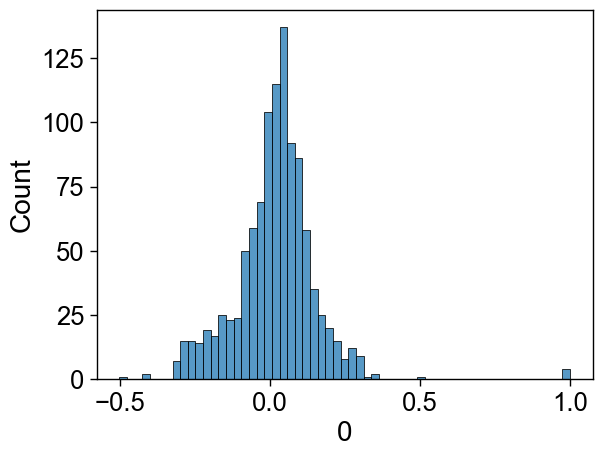

In [134]:

sns.histplot(corr_superscores_filt_stack[0])

In [135]:
# keep only correlations above a threshold and remove self correlations
corr_superscores_filt_stack_thresh = corr_superscores_filt_stack.loc[(abs(corr_superscores_filt_stack[0]) > 0.25) & (corr_superscores_filt_stack['level_0'] != corr_superscores_filt_stack['level_1'])]

In [136]:
corr_superscores_filt_stack['P-value'] = [spearmanr(md_superscore_bin[x].tolist(), md_superscore_bin[y].to_list(), nan_policy='omit')[1] for x, y in zip(corr_superscores_filt_stack['level_0'], corr_superscores_filt_stack['level_1'])]

In [137]:
corr_superscores_filt_stack['P-adjust'] = multipletests(corr_superscores_filt_stack['P-value'].values, alpha=0.05, method='bonferroni')[1]

In [363]:
corr_superscores_filt_stack

level_0  level_1         0   P-value  P-adjust
0                            Visit_Year        1 -0.061592  0.159970       1.0
1                            Visit_Year        2  0.120507  0.005838       1.0
2                            Visit_Year        3  0.063572  0.146937       1.0
3                            Visit_Year        4  0.051031  0.244473       1.0
4                   days_since_baseline        1 -0.093132  0.033391       1.0
...                                 ...      ...       ...       ...       ...
1059     Change P1-P2: Smoking Status_F        4  0.079899  0.068149       1.0
1060  Change P1-P2: Smoking Status_F->C        1  0.104849  0.016558       1.0
1061  Change P1-P2: Smoking Status_F->C        2 -0.046741  0.286457       1.0
1062  Change P1-P2: Smoking Status_F->C        3  0.036307  0.407784       1.0
1063  Change P1-P2: Smoking Status_F->C        4  0.018323  0.676192       1.0

[1064 rows x 5 columns]

In [138]:
corr_superscores_filt_pvals = corr_superscores_filt_stack.pivot(index='level_0', columns='level_1', values='P-adjust')

In [139]:
corr_superscores_filt_pvals.loc[corr_superscores_filt_stack_thresh.level_0,:]

level_1                         1             2             3             4
level_0                                                                    
days_since_baseline  1.000000e+00  7.931438e-09  7.753076e-01  1.000000e+00
years_from_baseline  1.000000e+00  7.931438e-09  7.753076e-01  1.000000e+00
Gender               4.227879e-07  2.527182e-05  1.000000e+00  1.000000e+00
Race of subject      1.000000e+00  1.000000e+00  8.895329e-07  1.000000e+00
age_baseline         2.642191e-12  1.000000e+00  1.692475e-07  2.457345e-03
...                           ...           ...           ...           ...
finalGoldP2_binary   7.180276e-07  3.491704e-05  4.730496e-07  1.649206e-08
ccenter_C08          1.000000e+00  6.449652e-32  1.694087e-01  1.000000e+00
ccenter_C09          1.000000e+00  6.449652e-32  1.694087e-01  1.000000e+00
O2_Therapy_1.0       1.018380e-03  1.000000e+00  2.154894e-07  1.000000e+00
NewGOLD_SGRQ_A       4.004688e-03  1.000000e+00  1.809427e-08  1.105784e-02

[66 rows x 4 columns]

In [140]:
data_dict_labels = pd.read_excel('D:/COPDgene/DataDict_labels.xlsx', header=2)

In [141]:
data_dict_labels['Label'].sort_values()

242       % gas trapping (-856), total lung, Thirona
31                          1-min post-walk Sa02 (%)
244                  Adjusted Lung density, CT model
243       Adjusted Lung density, plethy sponge model
5                   Age at current visit, DEPRECATED
                           ...                      
271    pct Emph REDUNDANT for backward compatibility
217                         pctEmph Lower Lobes Vida
270                       pctEmph Lower Third Slicer
216                         pctEmph Upper Lobes Vida
269                       pctEmph Upper Third Slicer
Name: Label, Length: 273, dtype: object

In [142]:
corr_superscores_filt_stack_thresh = corr_superscores_filt_stack_thresh[corr_superscores_filt_stack_thresh['level_0'] != 'Age at current visit, DEPRECATED']

In [143]:
corr_superscores_filt_stack_thresh = corr_superscores_filt_stack_thresh.drop_duplicates(subset='level_0')

In [144]:
corr_superscores_filt_stack_thresh

level_0  level_1         0
5                                   days_since_baseline        2 -0.293821
9                                   years_from_baseline        2 -0.293821
12                                               Gender        1 -0.269347
18                                      Race of subject        3 -0.264485
24                                         age_baseline        1  0.337029
28                                            age_visit        1  0.345406
402                                       CurrentMedUse        3  0.290450
454   Have shortness of breath when hurrying or slig...        3  0.251518
506                                     MMRCDyspneaScor        3  0.286374
562                              Have you ever had COPD        3  0.253468
617                                SGRQ score: Symptoms        2  0.274127
622                                  SGRQ score: Active        3  0.286935
629                                   SGRQ score: Total        2  0.257303
634                  SF-36 Physical Function (PF) score        3 -0.276933
666   SF-36 Physical Function (PF) t-score (normalized)        3 -0.276933
718                                     CAT4_breathless        3  0.274410
776                                       Pred_FEV1_FVC        1 -0.418875
780                                   Pred_FEV1_FVC_LLN        1 -0.419165
806                                           FEV1_post        3 -0.306601
812                                         FEV1pp_post        1 -0.253127
820                                       FEV1_FVC_post        1 -0.279116
826                                            PEF_post        3 -0.269909
828                                        FEF2575_post        1 -0.262664
834                                            FEV1_pre        3 -0.298076
840                                        FEV1_FVC_pre        1 -0.288757
848                                         FEF2575_pre        1 -0.258028
854                                           FEV1_utah        3 -0.306601
860                                       FEV1_FVC_utah        1 -0.279116
864                              FEV1 % pred, post-Utah        1 -0.253127
892                                             ATS_ERS        1  0.290857
896                                   GOLD stage, visit        1  0.286660
900                                    finalgold_Phase2        1  0.286660
925                                  Days_Phase1_Phase2        2 -0.282954
929                                 Years_Phase1_Phase2        2 -0.285456
956                                  finalGoldP2_binary        1  0.265895
977                                         ccenter_C08        2 -0.503778
981                                         ccenter_C09        2  0.503778
990                                      O2_Therapy_1.0        3  0.273669
1010                                     NewGOLD_SGRQ_A        3 -0.288937

In [145]:
keep_vars = [ 'Gender',
       'Race of subject', 'age_visit','CurrentMedUse',
       'SGRQ score: Total',  'CAT4_breathless',
       'Pred_FEV1_FVC',  'FEV1_post', 
       'FEV1_FVC_post','finalgold_Phase2',
       ]

In [146]:
corr_superscores_filt_stack_thresh = corr_superscores_filt_stack_thresh[corr_superscores_filt_stack_thresh['level_0'].isin(keep_vars)]

In [147]:
filtered_pvals = corr_superscores_filt_pvals.loc[corr_superscores_filt_stack_thresh.level_0,:]
# fig, g = plt.subplots(1, 1, figsize=(4, 10))


filtered_pvals_symb = filtered_pvals
# # Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(filtered_pvals.index):
    for j, jx in enumerate(filtered_pvals.columns):
        cell = filtered_pvals_symb.iloc[i, j]
        if cell <= 0.01:
            filtered_pvals_symb.iloc[i, j] = '*'
        else:
            filtered_pvals_symb.iloc[i, j] = ''

hmap_data = corr_superscores_filt.loc[corr_superscores_filt_stack_thresh.level_0,:]
print(hmap_data)

                          1         2         3         4
Gender            -0.269347 -0.241285 -0.014756  0.038925
Race of subject   -0.097040  0.068109 -0.264485  0.100542
age_visit          0.345406  0.006487  0.267860  0.207510
CurrentMedUse      0.165757  0.218339  0.290450  0.132082
SGRQ score: Total  0.181626  0.257303  0.269313  0.186533
CAT4_breathless    0.196388  0.033333  0.274410  0.166082
Pred_FEV1_FVC     -0.418875 -0.104575 -0.247716 -0.121792
FEV1_post         -0.200541 -0.078483 -0.306601 -0.270616
FEV1_FVC_post     -0.279116 -0.198599 -0.316689 -0.251605
finalgold_Phase2   0.286660  0.215407  0.310107  0.271640


In [148]:
hmap_data.index

Index(['Gender', 'Race of subject', 'age_visit', 'CurrentMedUse',
       'SGRQ score: Total', 'CAT4_breathless', 'Pred_FEV1_FVC', 'FEV1_post',
       'FEV1_FVC_post', 'finalgold_Phase2'],
      dtype='object')

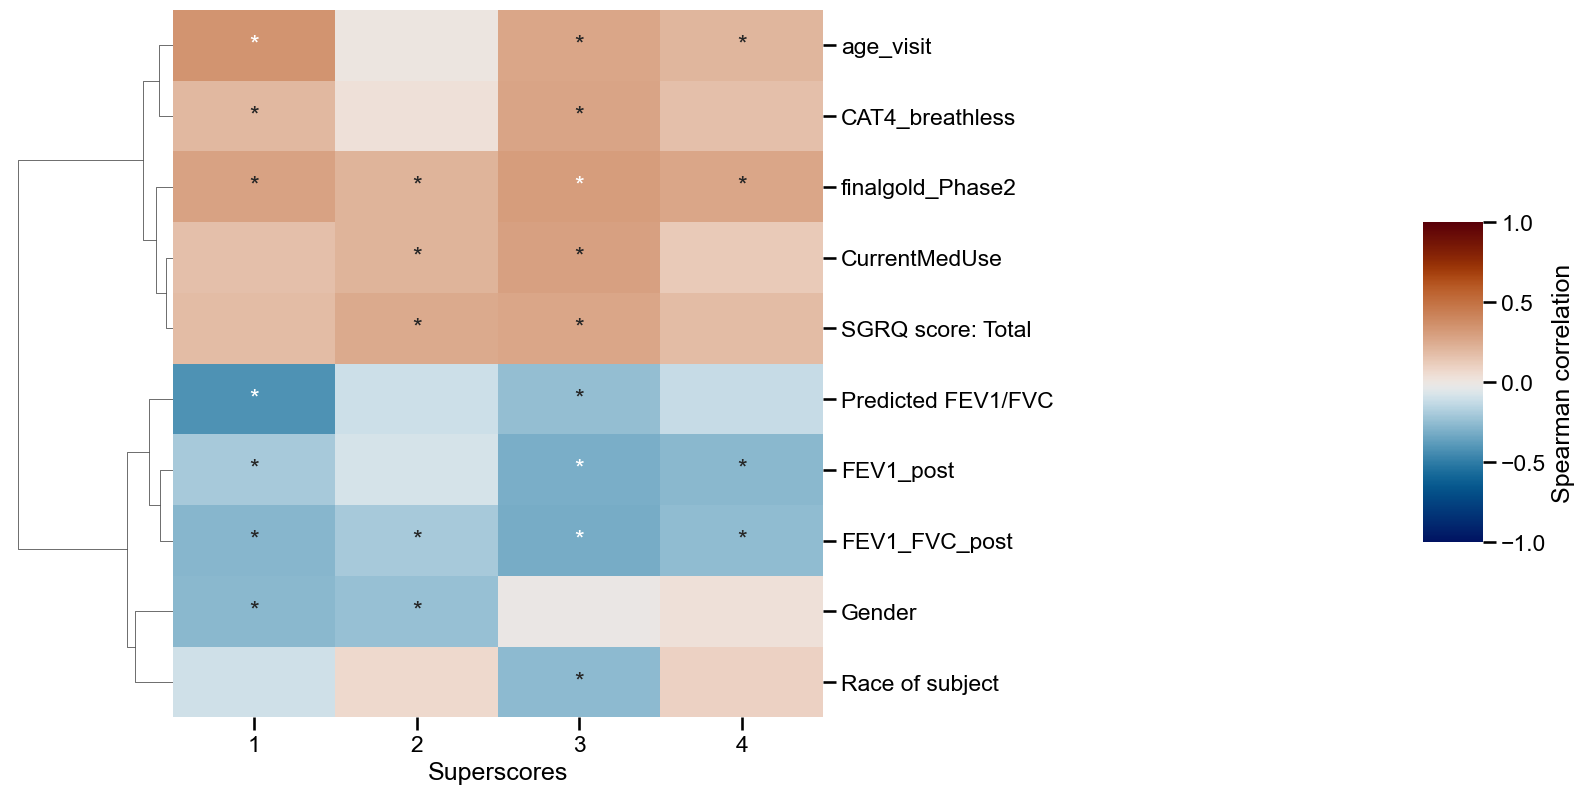

In [149]:

hmap_data = hmap_data.rename(index={
                                    'Pred_FEV1_FVC':'Predicted FEV1/FVC'})
sns.set_context('talk')
g = sns.clustermap(
    data=hmap_data,
    method='ward',
    cmap='cmc.vik',
    cbar_kws={'label': 'Spearman correlation'},
    vmin=-1,
    vmax=1,
    col_cluster=False,
    yticklabels=True,
    xticklabels=True,
    annot=filtered_pvals_symb,
    figsize=(12, 8),
    dendrogram_ratio=(0.2, 0), # This line 
    fmt='',
    square=True
)

# g.fig.suptitle('Superscore Spearman correlations with clinical metadata: P-adjust <= 0.05 and abs(R) >= 0.3')
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((1.2, .3, 0.05, .4))
g.ax_heatmap.set_xlabel("Superscores")
# plt.tight_layout()
# plt.savefig('../Figures/Superscore_correlation_MD.png', dpi=300, bbox_inches='tight')
plt.show()


In [150]:
# get order of rows from dendrogram
dendro_row = g.dendrogram_row.reordered_ind
print(dendro_row)

[2, 5, 9, 3, 4, 6, 7, 8, 0, 1]


In [151]:
hmap_data_reordered = hmap_data.iloc[dendro_row, :]

In [152]:
hmap_data_reordered

1         2         3         4
age_visit           0.345406  0.006487  0.267860  0.207510
CAT4_breathless     0.196388  0.033333  0.274410  0.166082
finalgold_Phase2    0.286660  0.215407  0.310107  0.271640
CurrentMedUse       0.165757  0.218339  0.290450  0.132082
SGRQ score: Total   0.181626  0.257303  0.269313  0.186533
Predicted FEV1/FVC -0.418875 -0.104575 -0.247716 -0.121792
FEV1_post          -0.200541 -0.078483 -0.306601 -0.270616
FEV1_FVC_post      -0.279116 -0.198599 -0.316689 -0.251605
Gender             -0.269347 -0.241285 -0.014756  0.038925
Race of subject    -0.097040  0.068109 -0.264485  0.100542

In [153]:

relplot_dat = hmap_data_reordered.melt(ignore_index=False).reset_index()
relplot_dat['value_abs'] = abs(relplot_dat['value'])

[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 2 3 4] [0, 1,

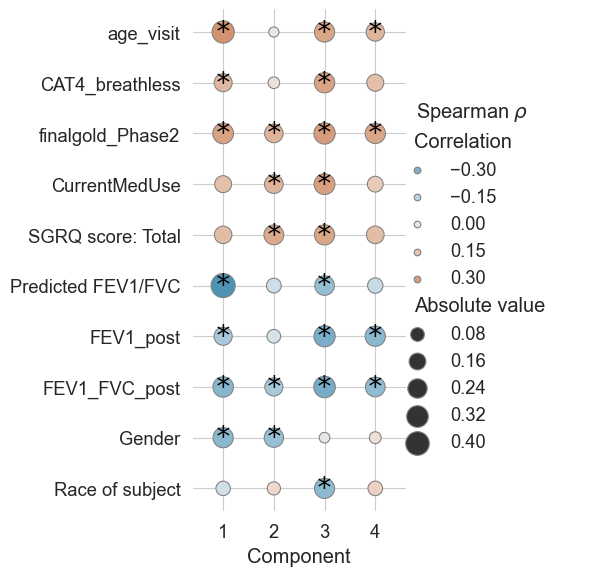

In [225]:
sns.set_context('paper', font_scale=1.5)
sns.set_style('whitegrid')


filtered_pvals_symb = filtered_pvals_symb.rename(index={'Have you ever had COPD': 'COPD',
                                    'Pred_FEV1_FVC':'Predicted FEV1/FVC'})
g = sns.relplot(
    data=relplot_dat,
    x="variable", y="index", hue="value", size="value_abs",
    palette="cmc.vik", hue_norm=(-1, 1), edgecolor="0.5",
    height=6, aspect=0.9, sizes=(50, 350), size_norm=(0,0.5)
)
g.set(xlabel="Component", ylabel="",  aspect="equal")
# set x tick labels
g.ax.set_xticks(range(1, 5))
g.set_xticklabels(range(1, 5))

g.despine(left=True, bottom=True)
g.ax.margins(x=0.2)

for idx,row in filtered_pvals_symb.iloc[dendro_row, :].melt(ignore_index=False).reset_index().iterrows():
    x = row[0]
    y = row[1]
    text = row[2]
    # get x and y coordinates

    g.ax.text(int(y), x, text, horizontalalignment='center', verticalalignment='center', color='k', fontsize=20, fontfamily='monospace')

for artist in g.legend.legendHandles:
    artist.set_edgecolor(".5")

# set legend title
g._legend.set_title("Spearman $\\rho$")
# move legend right
g._legend.set_bbox_to_anchor((0.85, 0.5))
# set legend subtitles
g._legend.texts[0].set_text("Correlation")

g._legend.texts[6].set_text("Absolute value")
# add space to right of plot
plt.subplots_adjust(left=0)


# plt.tight_layout()
# plt.savefig('D:/H_drive/Documents/pathway-integration/Figures/Superscore_correlation_GOLD_MD.png', dpi=350, bbox_inches='tight', transparent=True)
plt.show()

# Check for orthogonality

### Correlation between block scores

In [19]:
# unpack scores
# order 
cols = [x+str(i) for x in ['M', 'P', 'T'] for i in range(1, 5) ]
print(cols)
block_scores_df = pd.DataFrame(data=np.concatenate([m1_3o.T_[0], m1_3o.T_[1], m1_3o.T_[2]], axis=1), columns=cols)

['M1', 'M2', 'M3', 'M4', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']


In [119]:
block_scores_df

M1        M2        M3        M4         P1         P2         P3  \
0   -1.927578  0.865602  2.768342  5.307843 -32.891743  25.294011  27.011726   
1    3.086716  3.800903  6.095591  2.621573 -13.804353  -2.517351  -0.621176   
2   -2.282182 -4.842285 -3.366704 -4.698848   9.336735 -17.265984 -12.063936   
3    6.789075  6.458346  4.279931  1.955857  27.775934 -13.828660 -10.457930   
4   -6.609134 -7.025807 -5.976235 -0.468590  13.590573  -3.726063 -13.649466   
..        ...       ...       ...       ...        ...        ...        ...   
534  9.038022  4.869877  2.411635 -8.469219   5.024467  -1.452940   7.454945   
535  4.641866  6.540632  6.718176  2.662104   0.400926   7.932731   0.460687   
536  3.305668  3.161504  4.483136 -3.153413 -31.018779   2.280807   9.120156   
537  5.005947  4.539821  1.885125 -0.278721  11.725595   0.561323  -2.743493   
538 -3.705719 -5.383825 -2.783184  4.083711  18.367006   2.407785   1.428885   

            P4         T1         T2         T3         T4  
0    -9.974910  12.263454 -42.157550   7.796636 -11.446377  
1    -3.120176   5.623883 -36.983708   5.741043   4.697471  
2    -5.325081  24.054738 -15.458380 -15.030179 -11.981962  
3    15.084569   0.236149  33.692269  -8.067880   3.376830  
4   -11.314846   1.192826  -5.387906 -10.644994  -5.232536  
..         ...        ...        ...        ...        ...  
534  -2.539884  22.676322   2.553778  -7.502857  -9.628149  
535   1.875752  -8.505633 -15.435304  18.457318  20.437692  
536   1.005833  -6.446442 -44.624052   5.570934   2.670292  
537 -14.285020  16.459624  25.314878 -11.475584 -15.756487  
538  -7.188750  29.964718   2.950025  -6.242593  -8.754482  

[539 rows x 12 columns]

In [20]:
block_score_corr = block_scores_df.corr(method='spearman')

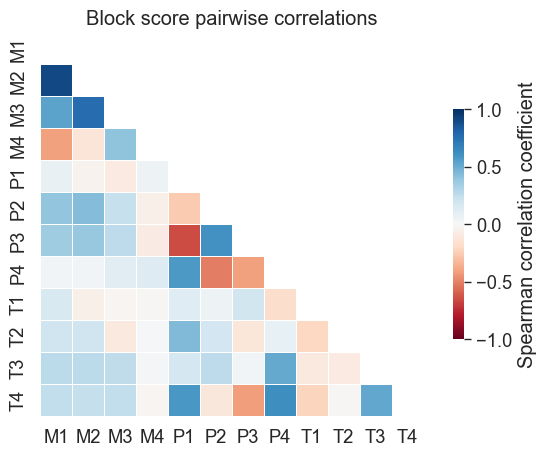

In [21]:
mask = np.triu(np.ones_like(block_score_corr, dtype=bool))

sns.heatmap(
    data=block_score_corr,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    square=True,
    linewidth=0.5,
    mask=mask,
    cbar_kws={"shrink": .6,
              'label':'Spearman correlation coefficient'}
)

plt.title('Block score pairwise correlations')

plt.tight_layout()
plt.show()

In [157]:
m1_3o.Ts_

array([[-0.0350532 , -0.04560088,  0.06630905, -0.05219858],
       [-0.01131972, -0.0660735 ,  0.012301  ,  0.00607472],
       [ 0.05388935, -0.04920507, -0.05082159, -0.04957144],
       ...,
       [-0.05961579, -0.07452139,  0.02953716,  0.00699435],
       [ 0.05004432,  0.04772145, -0.02394253, -0.07978497],
       [ 0.07764959,  0.00504231, -0.0097057 , -0.03871684]])

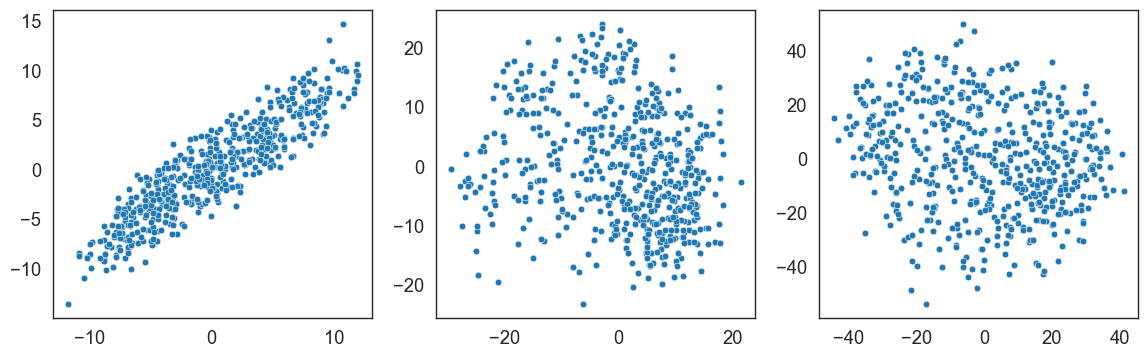

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14, 4))
sns.scatterplot(
    x=m1_3o.T_[0][:,0],
    y=m1_3o.T_[0][:,1],
    ax=ax1
)
sns.scatterplot(
    x=m1_3o.T_[1][:,0],
    y=m1_3o.T_[1][:,1],
    ax=ax2
)
sns.scatterplot(
    x=m1_3o.T_[2][:,0],
    y=m1_3o.T_[2][:,1],
    ax=ax3
)
plt.show()

<AxesSubplot:>

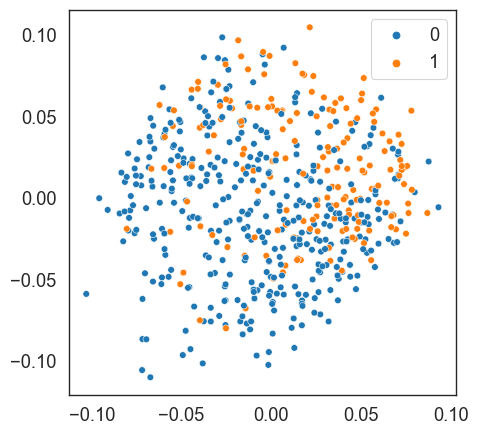

In [23]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=m1_3o.Ts_[:, 0],
    y=m1_3o.Ts_[:, 1],
    hue=labels
)

Correlation between superscores

In [293]:
m1_3o.Ts_.shape

(539, 4)

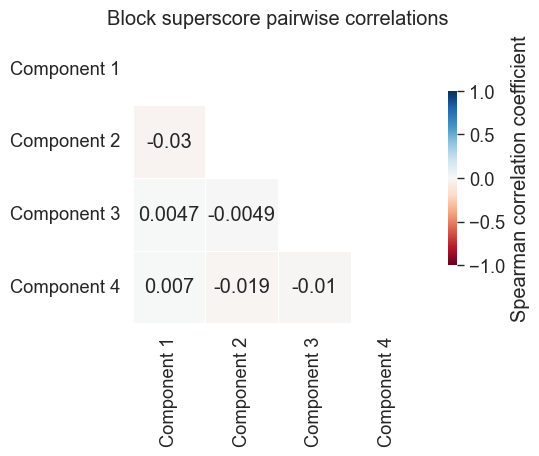

In [555]:
block_superscore_corr = pd.DataFrame(m1_3o.Ts_, columns=['Component ' + str(i) for i in range(1, 5)]).corr(method='spearman')
mask = np.triu(np.ones_like(block_superscore_corr, dtype=bool))

sns.heatmap(
    data=block_superscore_corr,
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    square=True,
    linewidth=0.5,
    mask=mask,
    cbar_kws={"shrink": .6,
              'label':'Spearman correlation coefficient'}
)

plt.title('Block superscore pairwise correlations')

plt.tight_layout()
plt.show()

## Bootstrap resampling - block importance
How does the contribution of each omics change with resampling?

Null model - Shuffling class labels

In [366]:
import random

In [167]:
(kpca_scores_prot['Group'] == kpca_scores_prot['Group']).value_counts()

True    539
Name: Group, dtype: int64

In [81]:
char_array3 = np.empty((3, 4), dtype='str')
char_array3[:] = ' '

In [82]:
char_array3

array([[' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U1')

Bootstrap resampling on samples

In [78]:
bips = []
explained_y = []
labels = pd.factorize(prot_scaled['Group'])[0]

for i in range(0, 100):

    m1_rnd = MBPLS(n_components=4)
    # sample features or samples?
    bootstrap_samps = kpca_scores_met.iloc[:, :-1].sample(n=600, replace=True, axis=0).index.tolist()
    met_bootstrap = kpca_scores_met.loc[bootstrap_samps]
    prot_bootstrap = kpca_scores_prot.loc[bootstrap_samps]
    trans_bootstrap = kpca_scores_trans.loc[bootstrap_samps]

    m1_rnd.fit([
    met_bootstrap,
    prot_bootstrap,
    trans_bootstrap],
    prot_scaled['Group'].loc[bootstrap_samps])

    bips.append(m1_rnd.A_corrected_)
    explained_y.append(m1_rnd.explained_var_y_)

In [79]:
print(np.mean(bips, axis=0))
print(np.std(bips, axis=0))

[[0.17003521 0.06548667 0.06296597 0.06434404]
 [0.40712404 0.2831674  0.50535482 0.61123733]
 [0.42284076 0.65134593 0.43167922 0.32441863]]
[[0.03846408 0.02298367 0.02106427 0.03582614]
 [0.08231827 0.17792324 0.16874879 0.16069664]
 [0.09059253 0.18246041 0.17036545 0.1479762 ]]


In [84]:

lab1 = np.core.defchararray.add(char_array3, np.around(np.mean(bips, axis=0)*100, 1).astype('str'))
lab0 = np.core.defchararray.add( lab1, ' (')
# lab2 = np.core.defchararray.add(lab0, np.around(np.std(bips, axis=0)*100, 1).astype('str'))
lab2 = np.core.defchararray.add(lab0, np.around(stats.sem(bips, axis=0)*100, 1).astype('str'))

lab3 = np.core.defchararray.add(lab2, ')')

In [90]:
np.mean(bips, axis=0)

array([[0.17003521, 0.06548667, 0.06296597, 0.06434404],
       [0.40712404, 0.2831674 , 0.50535482, 0.61123733],
       [0.42284076, 0.65134593, 0.43167922, 0.32441863]])

In [91]:
np.mean(explained_y, axis=0)

array([0.09648451, 0.08779882, 0.11293138, 0.10537476])

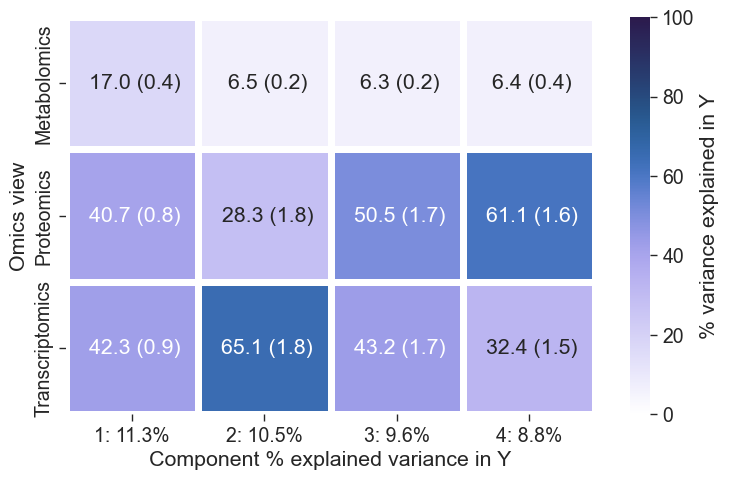

In [93]:
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')
plt.figure(figsize=(8, 5))
bips_df = pd.DataFrame(np.mean(bips, axis=0)*100)
bips_df = bips_df[[2, 3, 0, 1]]
sns.heatmap(np.mean(bips, axis=0)*100, cmap='cmc.devon_r', linewidth=5, square=True,
 cbar_kws={'label': '% variance explained in Y'},
 annot = lab3,
  fmt = '',
 vmin=0,
 vmax=100)
plt.yticks([0.5, 1.5, 2.5], ['Metabolomics', 'Proteomics', 'Transcriptomics'])
plt.xticks([i+0.5 for i in range(0, 4)], [str(n+1) + ': ' + str(np.around(i*100, 1))+'%' for n, i in enumerate(sorted(np.mean(explained_y, axis=0), reverse=True))])
# # plt.xticks([i+0.5 for i in range(0, 5)], range(1, 6))
plt.xlabel('Component % explained variance in Y')
plt.ylabel('Omics view')
plt.tight_layout()
plt.savefig('../Figures/MBPLS_COPD_Model1_3o_GOLD_block_importance_SEM.png', dpi=300)
plt.show()

In [170]:
betas = pd.DataFrame(m1_3o.beta_, index=kpca_scores_met.iloc[:, :-1].columns.tolist() +
    kpca_scores_prot.iloc[:, :-1].columns.tolist() + 
    kpca_scores_trans.iloc[:, :-1].columns.tolist())
betas['Name'] = betas.index.map(dict(zip(mo_paths.index, mo_paths['Pathway_name'])))
betas_sorted = betas.sort_values(by=0, key=abs, ascending=False)
betas_sorted

0                                               Name
R-HSA-200425   6.450014e-03                               Carnitine metabolism
R-HSA-6803157  5.778904e-03                             Antimicrobial peptides
R-HSA-390522   5.468992e-03                        Striated Muscle Contraction
R-HSA-8964043  5.076153e-03                       Plasma lipoprotein clearance
R-HSA-71403    5.008825e-03                      Citric acid cycle (TCA cycle)
...                     ...                                                ...
R-HSA-1227990 -3.958764e-06                       Signaling by ERBB2 in Cancer
R-HSA-2730905  3.893357e-06      Role of LAT2/NTAL/LAB on calcium mobilization
R-HSA-8939236 -3.535172e-06  RUNX1 regulates transcription of genes involve...
R-HSA-5660526  3.173770e-06                             Response to metal ions
R-HSA-983712  -5.341614e-08                              Ion channel transport

[3500 rows x 2 columns]

# Top pathways visulisation

In [58]:
def VIP_multiBlock(x_weights, x_superscores, x_loadings, y_loadings):
    # stack the weights from all blocks 
    weights = np.vstack(x_weights)
    # calculate product of sum of squares of superscores and y loadings
    sumsquares = np.sum(x_superscores**2, axis=0) * np.sum(y_loadings**2, axis=0)
    # p = number of variables - stack the loadings from all blocks
    p = np.vstack(x_loadings).shape[0]
    
    # VIP is a weighted sum of squares of PLS weights 
    vip_scores = np.sqrt(p * np.sum(sumsquares*(weights**2), axis=1) / np.sum(sumsquares))
    return vip_scores

def get_vips(mbpls_model, omics:dict, pvalues, by_source=True, top_n=5):
    vip = VIP_multiBlock(mbpls_model.W_, mbpls_model.Ts_, mbpls_model.P_, mbpls_model.V_)
    vip_df = pd.DataFrame(vip, index=sum([v.columns.tolist() for v in omics.values()], []))
    vip_df['Source'] = sum([[k] * v.shape[1] for k, v in omics.items()], [])
    vip_df['Name'] = vip_df.index.map(dict(zip(mo_paths_all.index, mo_paths_all['Pathway_name'])))
    vip_df['P-value'] = pvalues['P-value'].values
    vip_df['P-adjust'] = pvalues['P-adjust'].values

    if by_source:
        vip_df_source = vip_df.groupby(['Source'])[0].nlargest(top_n).reset_index()
        # vip_df_source = vip_df.groupby(['Source']).agg({0: 'nlargest(top_n)', 'P-value': 'first'})
        vip_df_source['Name'] = vip_df_source.level_1.map(dict(zip(mo_paths_all.index, mo_paths_all['Pathway_name'])))
        # vip_df_source['P-value'] = vip_df[vip_df.index.isin(vip_df_source.level_1)]['P-value'].values
        return vip_df_source
    else:
        # vip_df_all = vip_df.sort_values(by=0, ascending=False).iloc[0:top_n, :]
        # vip_df['VIP_scaled'] = vip_df.groupby('Source')[0].apply(lambda x: (x-x.mean())/(x.std()))

        vip_df['VIP_scaled'] = vip_df.groupby('Source')[0].transform(lambda x: StandardScaler().fit_transform(x.values[:,np.newaxis]).ravel())
        vip_df_all = vip_df.sort_values(by='VIP_scaled', ascending=False).iloc[0:top_n, :]
        return vip_df_all

In [59]:
vip_values = VIP_multiBlock(m1_3o.W_, m1_3o.Ts_, m1_3o.P_, m1_3o.V_)

In [60]:
pvals = pd.read_csv('A:/home/pathway-integration/Modelling_scripts/COPD_3o_GOLD_VIP_pvals.csv', index_col=0)

In [61]:
pvals

Observed  P-value  P-adjust
0     3.589434   0.6054  0.877743
1     7.065839   0.0766  0.877743
2     3.169956   0.7232  0.885402
3     2.744322   0.6558  0.877743
4     2.744322   0.6558  0.877743
...        ...      ...       ...
3495  1.335152   0.2989  0.877743
3496  1.192759   0.3397  0.877743
3497  1.072729   0.5375  0.877743
3498  1.623607   0.3654  0.877743
3499  1.731858   0.3005  0.877743

[3500 rows x 3 columns]

In [62]:
vip_values

array([3.58943398, 7.06583869, 3.16995589, ..., 1.07272907, 1.62360728,
       1.73185798])

In [63]:
kpca_scores_trans.shape[1] + kpca_scores_prot.shape[1] + kpca_scores_met.shape[1]


3500

In [64]:
pvals.index = kpca_scores_met.columns.tolist() + kpca_scores_prot.columns.tolist() + kpca_scores_trans.columns.tolist()

<AxesSubplot:ylabel='Observed'>

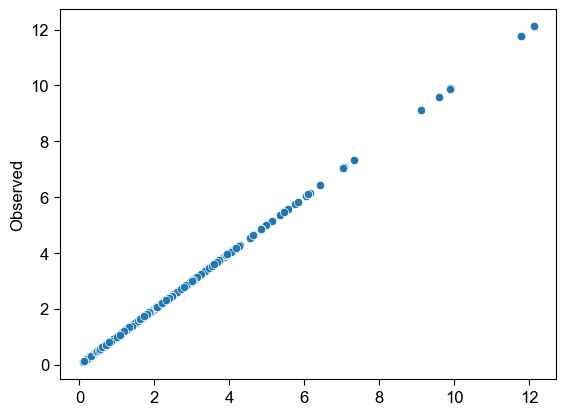

In [65]:
sns.scatterplot(
    x=vip_values,
    y=pvals['Observed']
)

In [68]:
vips_all = get_vips(m1_3o, omics={'Metabolomics': kpca_scores_met,
                       'Proteomics': kpca_scores_prot,
                       'Transcriptomics': kpca_scores_trans}, 
                       pvalues=pvals,
                         by_source=False, top_n=3500)

In [70]:
vips_all[vips_all['Name'] == 'Carnitine metabolism']

0           Source                  Name  P-value  \
R-HSA-200425  12.123272     Metabolomics  Carnitine metabolism   0.0031   
R-HSA-200425   0.959132  Transcriptomics  Carnitine metabolism   0.5517   

              P-adjust  VIP_scaled  
R-HSA-200425  0.877743    4.112169  
R-HSA-200425  0.877743   -0.886399

In [71]:
vips_all[vips_all['Name'] == 'Surfactant metabolism']

0           Source                   Name  P-value  \
R-HSA-5683826  3.585196       Proteomics  Surfactant metabolism   0.0021   
R-HSA-5683826  1.202430  Transcriptomics  Surfactant metabolism   0.3533   

               P-adjust  VIP_scaled  
R-HSA-5683826  0.877743    4.515197  
R-HSA-5683826  0.877743   -0.254944

In [173]:
vips_all.reset_index().to_csv('D:\PathIntegrate\src\pathintegrate\data/copd_pvals.csv')

In [97]:
vips_all.reset_index()

NameError: name 'vips_all' is not defined

In [604]:
vips_all.reset_index().groupby('index')['P-value'].min().to_dict()['R-HSA-390522']

0.0003162888771744

<AxesSubplot:xlabel='VIP_scaled', ylabel='P-value'>

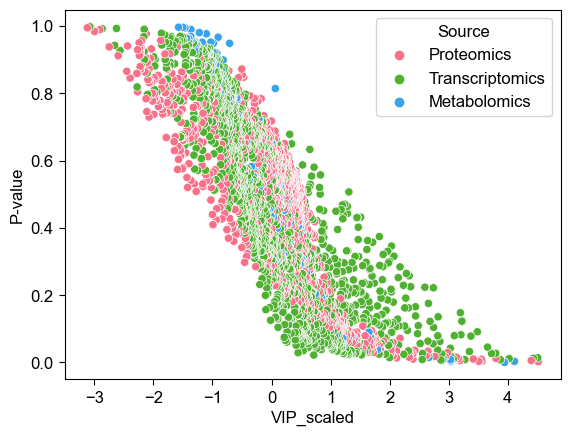

In [65]:
sns.scatterplot(data=vips_all, x='VIP_scaled', y='P-value', hue='Source', palette='husl')

In [66]:
vip_per_omics_idx = vips_all.reset_index(inplace=False).groupby(['Source'])[0].nlargest(5).index.get_level_values(1)
vip_per_omics = vips_all.reset_index(inplace=False).iloc[vip_per_omics_idx, :]

In [67]:
vip_per_omics

index          0           Source  \
4    R-HSA-200425  12.123272     Metabolomics   
6     R-HSA-70171  11.773112     Metabolomics   
7     R-HSA-70326  11.773112     Metabolomics   
32  R-HSA-8978868   9.899585     Metabolomics   
34    R-HSA-75105   9.887489     Metabolomics   
0   R-HSA-5683826   3.585196       Proteomics   
3    R-HSA-166665   3.530794       Proteomics   
9   R-HSA-8948216   3.257105       Proteomics   
13   R-HSA-381340   3.150664       Proteomics   
14  R-HSA-9637628   3.143692       Proteomics   
1    R-HSA-380994   3.037167  Transcriptomics   
2   R-HSA-8849473   3.007995  Transcriptomics   
5     R-HSA-70221   2.850221  Transcriptomics   
8   R-HSA-8857538   2.793524  Transcriptomics   
10   R-HSA-162791   2.762867  Transcriptomics   

                                                 Name  P-value  P-adjust  \
4                                Carnitine metabolism   0.0031  0.877743   
6                                          Glycolysis   0.0002  0.350000   
7                                  Glucose metabolism   0.0002  0.350000   
32                              Fatty acid metabolism   0.0026  0.877743   
34                        Fatty acyl-CoA biosynthesis   0.0048  0.877743   
0                               Surfactant metabolism   0.0021  0.877743   
3                      Terminal pathway of complement   0.0057  0.877743   
9                        Collagen chain trimerization   0.0120  0.877743   
13  Transcriptional regulation of white adipocyte ...   0.0048  0.877743   
14            Modulation by Mtb of host immune system   0.0095  0.877743   
1   ATF4 activates genes in response to endoplasmi...   0.0136  0.877743   
2                                     PTK6 Expression   0.0122  0.877743   
5                 Glycogen breakdown (glycogenolysis)   0.0113  0.877743   
8                   PTK6 promotes HIF1A stabilization   0.0079  0.877743   
10                   Attachment of GPI anchor to uPAR   0.0270  0.877743   

    VIP_scaled  
4     4.112169  
6     3.943004  
7     3.943004  
32    3.037885  
34    3.032042  
0     4.515197  
3     4.396509  
9     3.799404  
13    3.567183  
14    3.551972  
1     4.506930  
2     4.431218  
5     4.021729  
8     3.874579  
10    3.795013

In [70]:
vips_all.shape

(3500, 6)

<AxesSubplot:xlabel='0', ylabel='Name'>

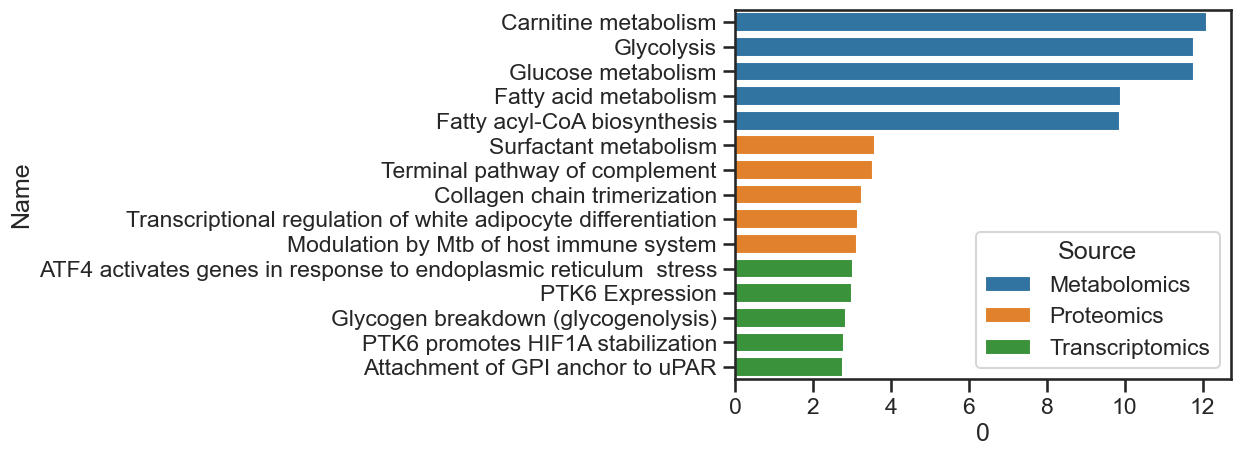

In [177]:
sns.barplot(
    orient='h',
    data=vip_per_omics,
    x=0,
    y='Name',
    hue='Source',
    dodge=False,
)

In [62]:
vips_all.head()

0           Source  \
R-HSA-6803157  5.053517       Proteomics   
R-HSA-390522   4.485853       Proteomics   
R-HSA-5660668  2.819003  Transcriptomics   
R-HSA-381426   4.006891       Proteomics   
R-HSA-9637628  3.910863       Proteomics   

                                                            Name   P-value  \
R-HSA-6803157                             Antimicrobial peptides  0.000105   
R-HSA-390522                         Striated Muscle Contraction  0.000316   
R-HSA-5660668                        CLEC7A/inflammasome pathway  0.014128   
R-HSA-381426   Regulation of Insulin-like Growth Factor (IGF)...  0.000738   
R-HSA-9637628            Modulation by Mtb of host immune system  0.000527   

               P-adjust  VIP_scaled  
R-HSA-6803157  0.369004    6.574935  
R-HSA-390522   0.553506    5.528255  
R-HSA-5660668  0.894934    4.810211  
R-HSA-381426   0.645756    4.645125  
R-HSA-9637628  0.615006    4.468064

In [479]:
vip_per_omics['Name'] = vip_per_omics['Name'].str.replace(r'((?:\w+\W+){6})', r'\1\n')

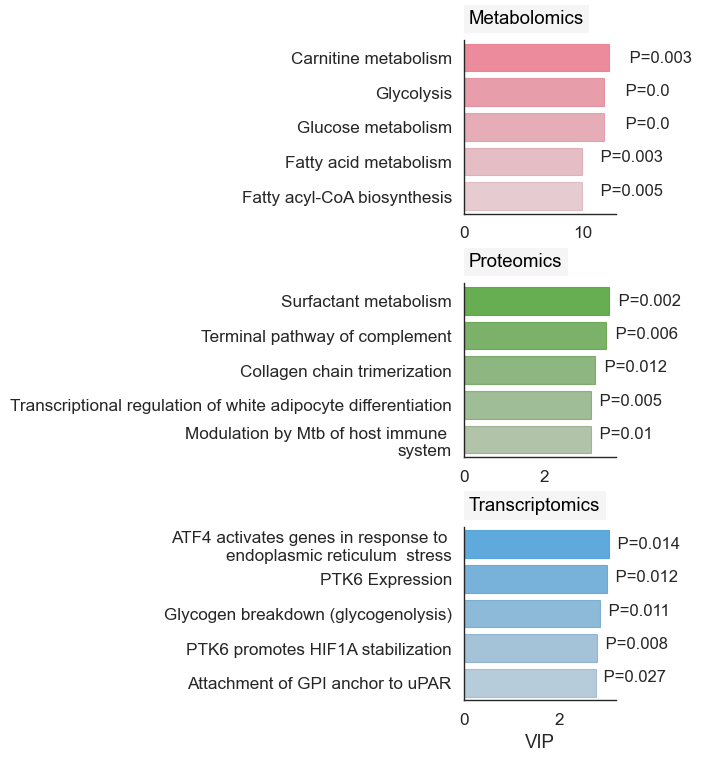

In [481]:
sns.set_style('white')
sns.set_context('paper', font_scale=1.4)
g = sns.catplot(
    data=vip_per_omics, y="Name", x=0, row="Source",
    kind="bar", orient='h', sharey=False, height=2.5, aspect=1, 
    palette='cmc.oslo_r', 
    sharex=False, 
)
count=0
for n, ax in enumerate(g.axes.ravel()):
  for m, p in enumerate(ax.patches):
      ax.annotate(" P="+ str(np.round(vip_per_omics.iloc[count, :]['P-value'], 3)), xy=(p.get_x() + p.get_width() , p.get_y() + p.get_height() /2),
                  textcoords='offset points', ha="left", va="center", fontsize=12)
      count += 1
g.despine(right=True)
g.set_titles("{row_name}",
  fontdict={'fontsize': 14,
 'fontweight': 'light',
 'color': 'k',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'left',
#  'backgroundcolor': 'lightgrey',
 'position':[0.03, 20],
 'bbox': {'facecolor': 'whitesmoke', 'pad': 5, 'boxstyle': 'square,pad=0.3'}},
 pad=12)
g.set_axis_labels("VIP", "")

# colour bars in each facet differently 
colours_omics = sns.color_palette('husl', n_colors=3)
for n, ax in enumerate(g.axes.ravel()):
    for i, bar in enumerate(ax.patches):
        bar.set_color(sns.desaturate(colours_omics[n], ((4-i)+4)/10))
        # change the alpha of each bar
        bar.set_alpha(((4-i)+5)/10)


# plt.xlabel('VIP')
plt.tight_layout()
plt.savefig('../Figures/COPD_M1_3o_GOLD_top_pathway_by_omics.png', dpi=350, bbox_inches='tight', transparent=True)
plt.show()

In [547]:
vips_all.Source.value_counts()

Proteomics         8
Transcriptomics    5
Metabolomics       2
Name: Source, dtype: int64

In [188]:
vips_all_sig = vips_all.sort_values(by=['VIP_scaled'], ascending=False).iloc[0:20, :]

In [189]:
vips_all_sig

0           Source  \
R-HSA-5683826   3.585196       Proteomics   
R-HSA-380994    3.037167  Transcriptomics   
R-HSA-8849473   3.007995  Transcriptomics   
R-HSA-166665    3.530794       Proteomics   
R-HSA-200425   12.123272     Metabolomics   
R-HSA-70221     2.850221  Transcriptomics   
R-HSA-70171    11.773112     Metabolomics   
R-HSA-70326    11.773112     Metabolomics   
R-HSA-8857538   2.793524  Transcriptomics   
R-HSA-8948216   3.257105       Proteomics   
R-HSA-162791    2.762867  Transcriptomics   
R-HSA-5357609   2.735737  Transcriptomics   
R-HSA-844615    2.709590  Transcriptomics   
R-HSA-381340    3.150664       Proteomics   
R-HSA-9637628   3.143692       Proteomics   
R-HSA-5638302   3.123094       Proteomics   
R-HSA-179812    3.123094       Proteomics   
R-HSA-5638303   3.123094       Proteomics   
R-HSA-4419969   2.643102  Transcriptomics   
R-HSA-8964058   3.080700       Proteomics   

                                                            Name  P-value  \
R-HSA-5683826                              Surfactant metabolism   0.0021   
R-HSA-380994   ATF4 activates genes in response to endoplasmi...   0.0136   
R-HSA-8849473                                    PTK6 Expression   0.0122   
R-HSA-166665                      Terminal pathway of complement   0.0057   
R-HSA-200425                                Carnitine metabolism   0.0031   
R-HSA-70221                  Glycogen breakdown (glycogenolysis)   0.0113   
R-HSA-70171                                           Glycolysis   0.0002   
R-HSA-70326                                   Glucose metabolism   0.0002   
R-HSA-8857538                  PTK6 promotes HIF1A stabilization   0.0079   
R-HSA-8948216                       Collagen chain trimerization   0.0120   
R-HSA-162791                    Attachment of GPI anchor to uPAR   0.0270   
R-HSA-5357609             Glycogen storage disease type II (GAA)   0.0265   
R-HSA-844615                               The AIM2 inflammasome   0.0454   
R-HSA-381340   Transcriptional regulation of white adipocyte ...   0.0048   
R-HSA-9637628            Modulation by Mtb of host immune system   0.0095   
R-HSA-5638302  Signaling by Overexpressed Wild-Type EGFR in C...   0.0034   
R-HSA-179812                       GRB2 events in EGFR signaling   0.0034   
R-HSA-5638303      Inhibition of Signaling by Overexpressed EGFR   0.0034   
R-HSA-4419969             Depolymerisation of the Nuclear Lamina   0.0910   
R-HSA-8964058                                     HDL remodeling   0.0100   

               P-adjust  VIP_scaled  
R-HSA-5683826  0.877743    4.515197  
R-HSA-380994   0.877743    4.506930  
R-HSA-8849473  0.877743    4.431218  
R-HSA-166665   0.877743    4.396509  
R-HSA-200425   0.877743    4.112169  
R-HSA-70221    0.877743    4.021729  
R-HSA-70171    0.350000    3.943004  
R-HSA-70326    0.350000    3.943004  
R-HSA-8857538  0.877743    3.874579  
R-HSA-8948216  0.877743    3.799404  
R-HSA-162791   0.877743    3.795013  
R-HSA-5357609  0.877743    3.724600  
R-HSA-844615   0.877743    3.656738  
R-HSA-381340   0.877743    3.567183  
R-HSA-9637628  0.877743    3.551972  
R-HSA-5638302  0.877743    3.507035  
R-HSA-179812   0.877743    3.507035  
R-HSA-5638303  0.877743    3.507035  
R-HSA-4419969  0.877743    3.484174  
R-HSA-8964058  0.877743    3.414544

NameError: name 'vips_all_sig' is not defined

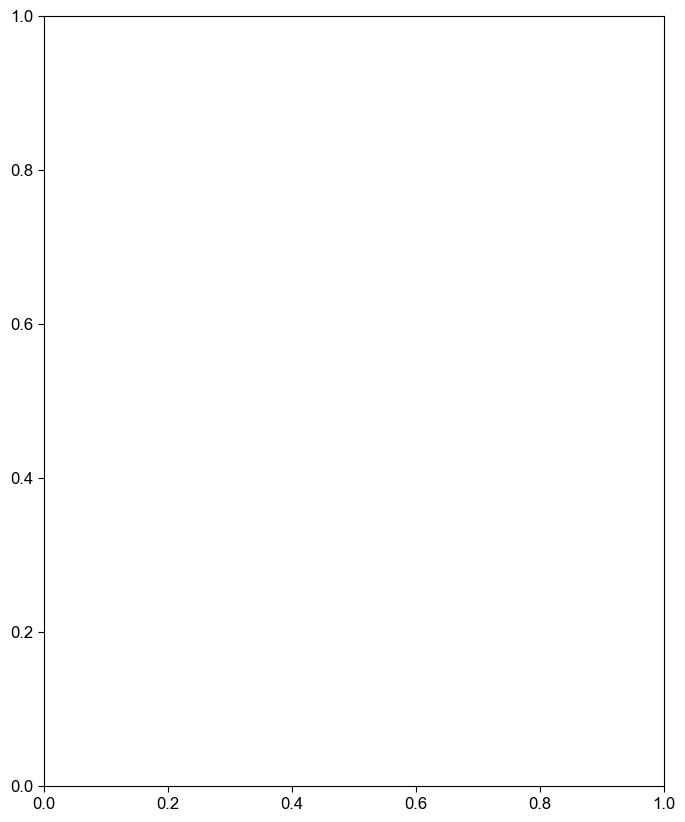

In [68]:
from matplotlib.patches import Patch
fig, p = plt.subplots(1, 1, figsize=(8, 10), sharey=False, sharex=False)
sns.set_style('whitegrid')
color_map = {'Metabolomics': 'tab:blue', 'Proteomics': 'tab:orange', 'Transcriptomics':'tab:green'}
p = sns.barplot(
    orient='h',
    data=vips_all_sig,
    y='Name',
    x='VIP_scaled',
    palette=[color_map[i] for i in vips_all_sig['Source']]
    # hue='Source',
)

box = p.get_position()
p.set_position([box.x0 * .8, box.y0, box.width * 0.8, box.height])

for i, pval in zip(p.patches, vips_all_sig['P-value']):
    p.annotate(" P="+str(pval), xy=(4.6, i.get_y()+i.get_height()/2),
            xytext=(0.1, 0), textcoords='offset points', ha="left", va="center")



legend_elements = [Patch(facecolor='tab:blue',label='Metabolomics'), 
                Patch(facecolor='tab:orange',label='Proteomics'), 
                Patch(facecolor='tab:green',label='Transcriptomics')]
plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.title('Top 15 pathways by VIP')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Source', ylabel='0'>

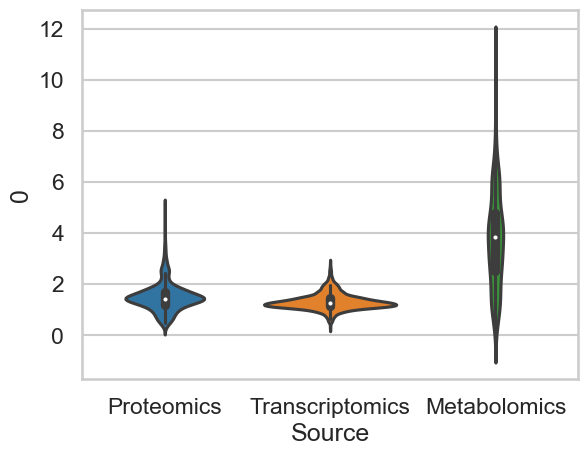

In [267]:
sns.violinplot(
    data=vips_all,
    y=0,
    x='Source'
)

<AxesSubplot:xlabel='0', ylabel='Density'>

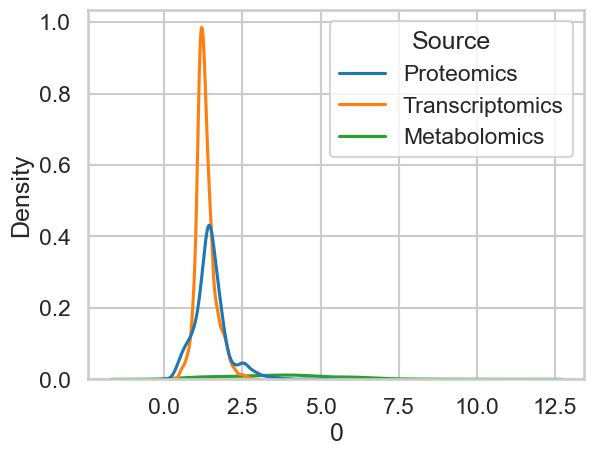

In [268]:
sns.kdeplot(vips_all,
             x=0,
             hue='Source')

<AxesSubplot:xlabel='Source', ylabel='VIP_scaled'>

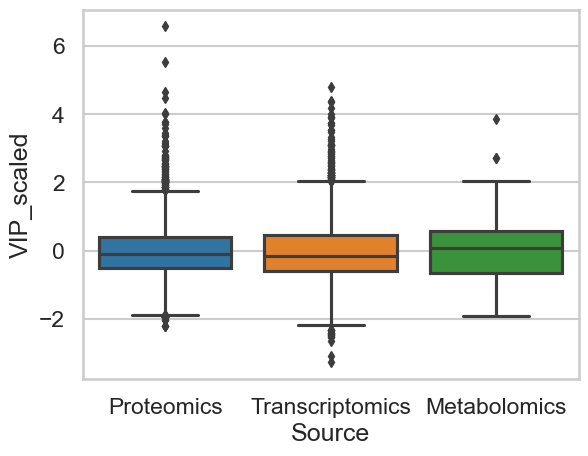

In [269]:
sns.boxplot(
    data=vips_all,
    y='VIP_scaled',
    x='Source'
)

Cluster samples by top pathways:

In [69]:
vips_all_sig = vips_all.sort_values(by=['VIP_scaled'], ascending=False).iloc[0:15, :]

In [70]:
vips_all[vips_all['Name'] == 'Striated Muscle Contraction']

0           Source                         Name  P-value  \
R-HSA-390522  2.088720       Proteomics  Striated Muscle Contraction   0.1141   
R-HSA-390522  0.885851  Transcriptomics  Striated Muscle Contraction   0.8306   

              P-adjust  VIP_scaled  
R-HSA-390522  0.877743    1.250352  
R-HSA-390522  0.911317   -1.076593

In [71]:
vips_all_sig

0           Source  \
R-HSA-5683826   3.585196       Proteomics   
R-HSA-380994    3.037167  Transcriptomics   
R-HSA-8849473   3.007995  Transcriptomics   
R-HSA-166665    3.530794       Proteomics   
R-HSA-200425   12.123272     Metabolomics   
R-HSA-70221     2.850221  Transcriptomics   
R-HSA-70171    11.773112     Metabolomics   
R-HSA-70326    11.773112     Metabolomics   
R-HSA-8857538   2.793524  Transcriptomics   
R-HSA-8948216   3.257105       Proteomics   
R-HSA-162791    2.762867  Transcriptomics   
R-HSA-5357609   2.735737  Transcriptomics   
R-HSA-844615    2.709590  Transcriptomics   
R-HSA-381340    3.150664       Proteomics   
R-HSA-9637628   3.143692       Proteomics   

                                                            Name  P-value  \
R-HSA-5683826                              Surfactant metabolism   0.0021   
R-HSA-380994   ATF4 activates genes in response to endoplasmi...   0.0136   
R-HSA-8849473                                    PTK6 Expression   0.0122   
R-HSA-166665                      Terminal pathway of complement   0.0057   
R-HSA-200425                                Carnitine metabolism   0.0031   
R-HSA-70221                  Glycogen breakdown (glycogenolysis)   0.0113   
R-HSA-70171                                           Glycolysis   0.0002   
R-HSA-70326                                   Glucose metabolism   0.0002   
R-HSA-8857538                  PTK6 promotes HIF1A stabilization   0.0079   
R-HSA-8948216                       Collagen chain trimerization   0.0120   
R-HSA-162791                    Attachment of GPI anchor to uPAR   0.0270   
R-HSA-5357609             Glycogen storage disease type II (GAA)   0.0265   
R-HSA-844615                               The AIM2 inflammasome   0.0454   
R-HSA-381340   Transcriptional regulation of white adipocyte ...   0.0048   
R-HSA-9637628            Modulation by Mtb of host immune system   0.0095   

               P-adjust  VIP_scaled  
R-HSA-5683826  0.877743    4.515197  
R-HSA-380994   0.877743    4.506930  
R-HSA-8849473  0.877743    4.431218  
R-HSA-166665   0.877743    4.396509  
R-HSA-200425   0.877743    4.112169  
R-HSA-70221    0.877743    4.021729  
R-HSA-70171    0.350000    3.943004  
R-HSA-70326    0.350000    3.943004  
R-HSA-8857538  0.877743    3.874579  
R-HSA-8948216  0.877743    3.799404  
R-HSA-162791   0.877743    3.795013  
R-HSA-5357609  0.877743    3.724600  
R-HSA-844615   0.877743    3.656738  
R-HSA-381340   0.877743    3.567183  
R-HSA-9637628  0.877743    3.551972

In [72]:
kpca_scores_prot_top_vip = kpca_scores_prot.loc[:, kpca_scores_prot.columns.isin(vips_all_sig[vips_all_sig['Source'] == 'Proteomics'].index)]
kpca_scores_trans_top_vip = kpca_scores_trans.loc[:, kpca_scores_trans.columns.isin(vips_all_sig[vips_all_sig['Source'] == 'Transcriptomics'].index)]
kpca_scores_met_top_vip = kpca_scores_met.loc[:, kpca_scores_met.columns.isin(vips_all_sig[vips_all_sig['Source'] == 'Metabolomics'].index)]

In [73]:
kpca_top_vip = pd.concat([kpca_scores_prot_top_vip, kpca_scores_trans_top_vip, kpca_scores_met_top_vip], axis=1)

In [74]:
kpca_top_vip = kpca_top_vip.rename(columns=dict(zip(mo_paths_all.index, mo_paths_all['Pathway_name'])))

In [75]:
kpca_top_vip.columns = kpca_top_vip.columns.str.replace(r'((?:\w+\W+){9})', r'\1\n')

In [76]:
kpca_top_vip

Terminal pathway of complement  \
13217U                       -0.575361   
21433W                       -0.228792   
22068E                       -0.125506   
19577C                       -0.011819   
17573K                       -0.334029   
...                                ...   
21184B                       -0.277625   
14261C                        0.148419   
11933K                        0.050289   
14175J                       -0.133626   
25019G                        0.017959   

        Transcriptional regulation of white adipocyte differentiation  \
13217U                                          -0.147070               
21433W                                          -0.423411               
22068E                                          -0.159013               
19577C                                           0.434503               
17573K                                           0.307307               
...                                                   ...               
21184B                                           0.247593               
14261C                                           0.178076               
11933K                                           0.076416               
14175J                                          -0.134448               
25019G                                          -0.285132               

        Surfactant metabolism  Collagen chain trimerization  \
13217U              -0.465176                      0.133478   
21433W               0.133773                      0.055485   
22068E              -0.510886                      0.321265   
19577C              -0.488121                      0.197174   
17573K               0.040590                     -0.111915   
...                       ...                           ...   
21184B              -0.089178                      0.559357   
14261C              -0.537234                     -0.147276   
11933K               0.566238                      0.347630   
14175J              -0.258102                     -0.220554   
25019G               0.565174                      0.336038   

        Modulation by Mtb of host immune system  \
13217U                                -0.188561   
21433W                                 0.344291   
22068E                                -0.340801   
19577C                                 0.166524   
17573K                                 0.358262   
...                                         ...   
21184B                                 0.341310   
14261C                                -0.295729   
11933K                                 0.222297   
14175J                                 0.296815   
25019G                                 0.572791   

        Attachment of GPI anchor to uPAR  \
13217U                          0.141114   
21433W                          0.003194   
22068E                          0.470835   
19577C                          0.527361   
17573K                          0.275330   
...                                  ...   
21184B                         -0.398398   
14261C                         -0.126681   
11933K                         -0.022851   
14175J                          0.555337   
25019G                          0.251808   

        ATF4 activates genes in response to endoplasmic reticulum  stress  \
13217U                                          -0.193089                   
21433W                                           0.084064                   
22068E                                           0.112362                   
19577C                                          -0.446009                   
17573K                                          -0.160070                   
...                                                   ...                   
21184B                                          -0.160718                   
14261C                                           0.446681                   
11933K                            

In [229]:
metab.Group.unique()

array([1., 0.])

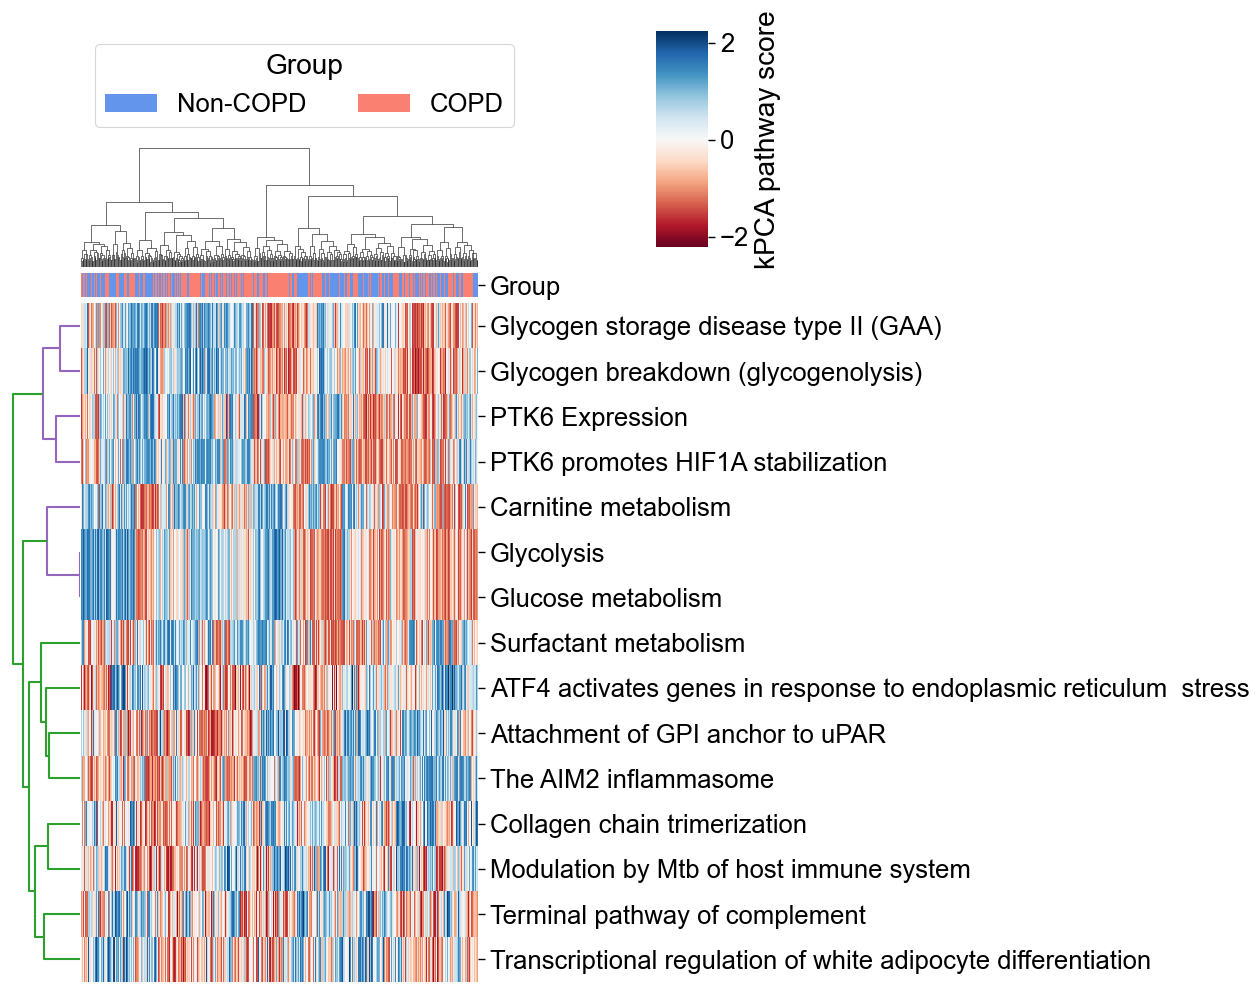

In [114]:
copd_dict = dict(zip(sorted(metab.Group.unique()), ['cornflowerblue', 'salmon']))
label_dict = {1: 'COPD', 0:'Non-COPD'}
sns.set_context('paper', font_scale=2.1)
g = sns.clustermap(
    data=kpca_top_vip.T,
    z_score=0,
    cmap='RdBu',
    cbar_kws={'label': 'kPCA pathway score'},
    method='ward',
    col_colors=metab.Group.map(copd_dict),
    dendrogram_ratio=0.15,
    figsize=(13, 9),
    xticklabels=False,
    yticklabels=True,
)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1.5)
    a.set_color(['tab:purple']*5+['tab:green']*9)
    # 
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([x0 + 0.5, 0.85, 0.04, 0.24])

from matplotlib.pyplot import gcf

for label in list(set(metab["Group"])):
    g.ax_row_dendrogram.bar(0, 0, color=copd_dict[label], label=label_dict[label], linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Group', loc="center", ncol=2, bbox_to_anchor=(0.25, 1.03), bbox_transform=gcf().transFigure)
# plt.tight_layout()
plt.savefig('D:/H_drive/Documents/pathway-integration/Figures/COPDgene_m1_3o_GOLD_top_paths_clustering_v2.png', dpi=350, bbox_inches='tight')
plt.show()

In [275]:
metab.Group.map(copd_dict)

sid
19154A            salmon
22172Z    cornflowerblue
23989B            salmon
23372M    cornflowerblue
20899L    cornflowerblue
               ...      
13132M    cornflowerblue
24182M            salmon
16842G            salmon
22796L    cornflowerblue
15990Q            salmon
Name: Group, Length: 522, dtype: object

In [291]:
md_gold = md[md['sid'].isin(metab.index)][['sid','finalgold_Phase2']].set_index('sid')

In [286]:
md_gold

sid  finalgold_Phase2
10     10010J               2.0
42     10052Z               4.0
51     10060Y               2.0
78     10086Q               2.0
82     10088U               0.0
...       ...               ...
15864  25406N               2.0
15902  25441P               0.0
15985  25537C               0.0
16001  25563D               0.0
16009  25571C               0.0

[522 rows x 2 columns]

In [289]:
md_gold.finalgold_Phase2.map(gold_dict)

10       (0.20125317221201128, 0.6907920815379025, 0.47...
42       (0.8004936186423958, 0.47703363533737203, 0.95...
51       (0.20125317221201128, 0.6907920815379025, 0.47...
78       (0.20125317221201128, 0.6907920815379025, 0.47...
82       (0.9677975592919913, 0.44127456009157356, 0.53...
                               ...                        
15864    (0.20125317221201128, 0.6907920815379025, 0.47...
15902    (0.9677975592919913, 0.44127456009157356, 0.53...
15985    (0.9677975592919913, 0.44127456009157356, 0.53...
16001    (0.9677975592919913, 0.44127456009157356, 0.53...
16009    (0.9677975592919913, 0.44127456009157356, 0.53...
Name: finalgold_Phase2, Length: 522, dtype: object

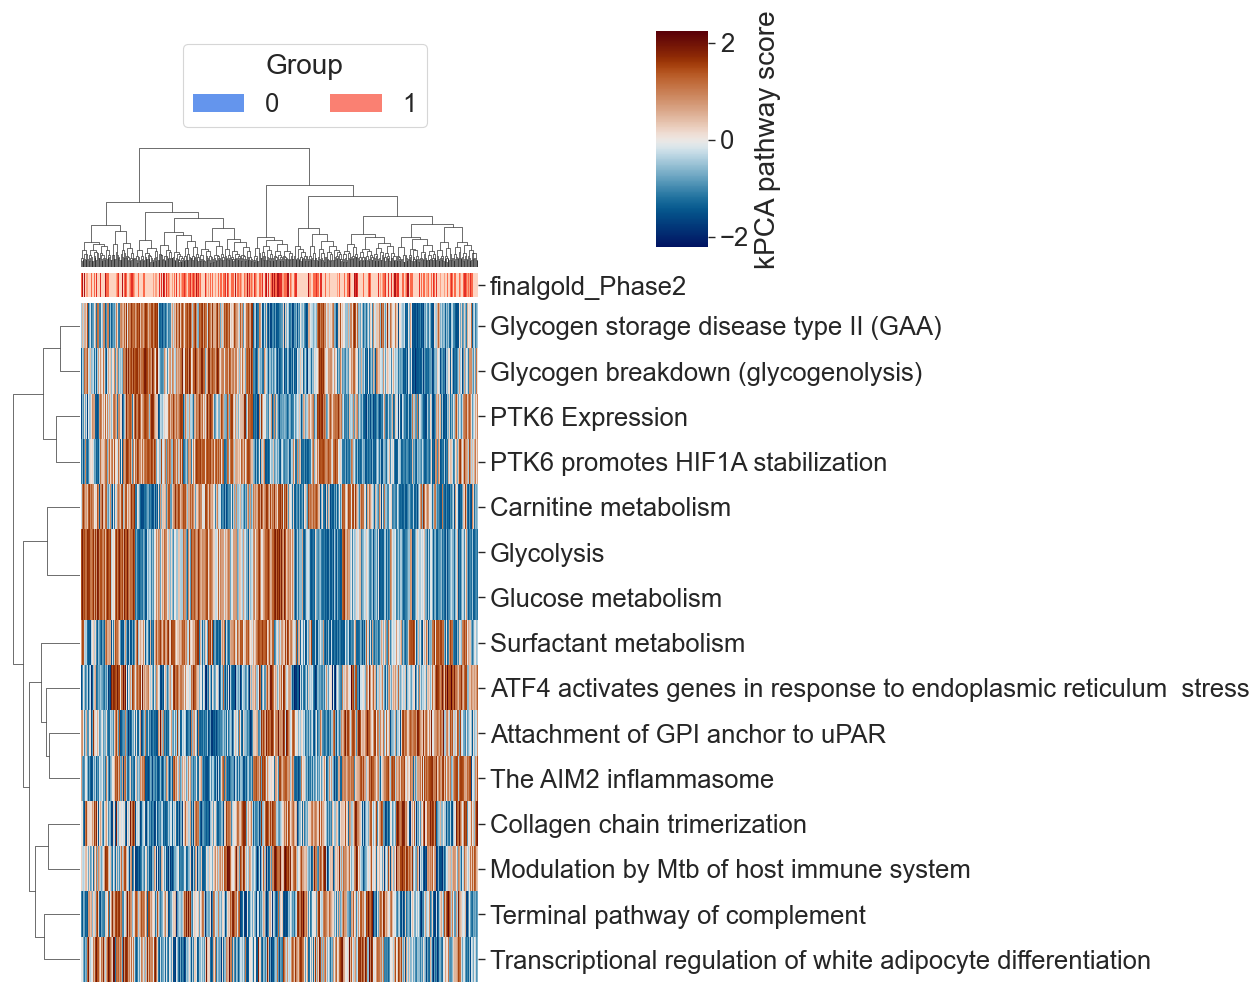

In [293]:
gold_dict = dict(zip(sorted(md_gold['finalgold_Phase2'].unique()), sns.color_palette('Reds', n_colors=5)))
label_dict = {0: '0', 1:'1', 2:'2', 3:'3', 4:'4'}
sns.set_context('paper', font_scale=2.1)
g = sns.clustermap(
    data=kpca_top_vip.T,
    z_score=0,
    cmap='cmc.vik',
    cbar_kws={'label': 'kPCA pathway score'},
    method='ward',
    col_colors=md_gold.finalgold_Phase2.map(gold_dict),
    dendrogram_ratio=0.15,
    figsize=(13, 9),
    xticklabels=False,
    yticklabels=True
    )
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([x0 + 0.5, 0.85, 0.04, 0.24])

from matplotlib.pyplot import gcf

for label in list(set(metab["Group"])):
    g.ax_row_dendrogram.bar(0, 0, color=copd_dict[label], label=label_dict[label], linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Group', loc="center", ncol=2, bbox_to_anchor=(0.25, 1.03), bbox_transform=gcf().transFigure)
# plt.tight_layout()
# plt.savefig('../Figures/COPDgene_m1_3o_GOLD_top_paths_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

In [1028]:
kpca_top_vip.columns

Index(['Caspase activation via Death Receptors in the presence of ligand',
       'Striated Muscle Contraction',
       'Ras activation upon Ca2+ influx through NMDA receptor',
       'Caspase activation via extrinsic apoptotic signalling pathway',
       'Dectin-2 family', 'Regulation of TLR by endogenous ligand',
       'Antimicrobial peptides', 'Modulation by Mtb of host immune system',
       'Displacement of DNA glycosylase by APEX1',
       'Caspase activation via Death Receptors in the presence of ligand',
       'Carnitine metabolism',
       'Synthesis of epoxy (EET) and dihydroxyeicosatrienoic acids (DHET)',
       'Striated Muscle Contraction',
       'Ras activation upon Ca2+ influx through NMDA receptor',
       'Caspase activation via extrinsic apoptotic signalling pathway',
       'Defective GCLC causes HAGGSD', 'Dectin-2 family',
       'CLEC7A/inflammasome pathway', 'Regulation of TLR by endogenous ligand',
       'Antimicrobial peptides',
       'RUNX1 regulates trans

In [1046]:
kpca_top_vip['Regulation of TLR by endogenous ligand']

Regulation of TLR by endogenous ligand  \
14147E                                0.408630   
18972D                               -0.291600   
22209W                               -0.425513   
23743V                                0.257138   
21608F                               -0.046178   
...                                        ...   
19318E                               -0.064012   
20609C                                0.420046   
24182M                               -0.128417   
17467L                                0.138193   
18793D                               -0.072568   

        Regulation of TLR by endogenous ligand  
14147E                               -0.209718  
18972D                               -0.414887  
22209W                               -0.050877  
23743V                                0.446229  
21608F                                0.018248  
...                                        ...  
19318E                                0.332642  
20609C                               -0.306844  
24182M                               -0.271757  
17467L                                0.466040  
18793D                                0.239961  

[539 rows x 2 columns]

Cluster pathways by root 

In [232]:
import networkx as nx

In [233]:
# creating graph
hierarchy = pd.read_csv('D:/Pathway_databases/ReactomePathwaysRelation.txt', sep='\t', header=None)
hierarchy_hsa = hierarchy[hierarchy[0].str.contains('HSA')]
hierarchy_hsa_parents = np.setdiff1d(hierarchy_hsa[0], hierarchy_hsa[1])
hierarchy_hsa_all = pd.concat([hierarchy_hsa, pd.DataFrame([hierarchy_hsa_parents, hierarchy_hsa_parents], index=[0, 1]).T])
G = nx.from_pandas_edgelist(hierarchy_hsa, source=0, target=1, create_using=nx.DiGraph())
def find_root(G,child):
    parent = list(G.predecessors(child))
    if len(parent) == 0:
        return child
    else:  
        return find_root(G, parent[0])

hierarchy_hsa_all['Root'] = [find_root(G, i) for i in hierarchy_hsa_all[1]]
hierarchy_hsa_all.columns = ['Parent', 'Child', 'Root']

In [234]:
vips_all['Root'] = vips_all.index.map(dict(zip(hierarchy_hsa_all['Child'], hierarchy_hsa_all['Root'])))
vips_all['Root_name'] = vips_all['Root'].map(dict(zip(mo_paths_all.index, mo_paths_all['Pathway_name'])))

In [235]:
vips_all = vips_all.dropna(axis=0)

In [236]:
vips_all.head()

0           Source  \
R-HSA-5683826   3.585196       Proteomics   
R-HSA-380994    3.037167  Transcriptomics   
R-HSA-8849473   3.007995  Transcriptomics   
R-HSA-166665    3.530794       Proteomics   
R-HSA-200425   12.123272     Metabolomics   

                                                            Name  P-value  \
R-HSA-5683826                              Surfactant metabolism   0.0021   
R-HSA-380994   ATF4 activates genes in response to endoplasmi...   0.0136   
R-HSA-8849473                                    PTK6 Expression   0.0122   
R-HSA-166665                      Terminal pathway of complement   0.0057   
R-HSA-200425                                Carnitine metabolism   0.0031   

               P-adjust  VIP_scaled           Root  \
R-HSA-5683826  0.877743    4.515197   R-HSA-392499   
R-HSA-380994   0.877743    4.506930  R-HSA-8953897   
R-HSA-8849473  0.877743    4.431218   R-HSA-162582   
R-HSA-166665   0.877743    4.396509   R-HSA-168256   
R-HSA-200425   0.877743    4.112169  R-HSA-1430728   

                                   Root_name  
R-HSA-5683826         Metabolism of proteins  
R-HSA-380994   Cellular responses to stimuli  
R-HSA-8849473            Signal Transduction  
R-HSA-166665                   Immune System  
R-HSA-200425                      Metabolism

In [237]:
vips_all_sorted = vips_all.sort_values(by=['P-value'], ascending=True)

In [238]:
vips_all_sorted = vips_all_sorted.rename(columns={0:'MB-VIP'})

In [239]:
vips_all_sorted

MB-VIP           Source  \
R-HSA-70326    11.773112     Metabolomics   
R-HSA-70171    11.773112     Metabolomics   
R-HSA-5683826   3.585196       Proteomics   
R-HSA-8978868   9.899585     Metabolomics   
R-HSA-200425   12.123272     Metabolomics   
...                  ...              ...   
R-HSA-444473    0.086491       Proteomics   
R-HSA-420499    0.503166     Metabolomics   
R-HSA-9717207   0.355384     Metabolomics   
R-HSA-6788467   0.115168  Transcriptomics   
R-HSA-70350     0.117619  Transcriptomics   

                                                            Name  P-value  \
R-HSA-70326                                   Glucose metabolism   0.0002   
R-HSA-70171                                           Glycolysis   0.0002   
R-HSA-5683826                              Surfactant metabolism   0.0021   
R-HSA-8978868                              Fatty acid metabolism   0.0026   
R-HSA-200425                                Carnitine metabolism   0.0031   
...                                                          ...      ...   
R-HSA-444473   Formyl peptide receptors bind formyl peptides ...   0.9946   
R-HSA-420499   Class C/3 (Metabotropic glutamate/pheromone re...   0.9962   
R-HSA-9717207  Sensory perception of sweet, bitter, and umami...   0.9964   
R-HSA-6788467    IL-6-type cytokine receptor ligand interactions   0.9974   
R-HSA-70350                                  Fructose catabolism   0.9990   

               P-adjust  VIP_scaled           Root               Root_name  
R-HSA-70326    0.350000    3.943004  R-HSA-1430728              Metabolism  
R-HSA-70171    0.350000    3.943004  R-HSA-1430728              Metabolism  
R-HSA-5683826  0.877743    4.515197   R-HSA-392499  Metabolism of proteins  
R-HSA-8978868  0.877743    3.037885  R-HSA-1430728              Metabolism  
R-HSA-200425   0.877743    4.112169  R-HSA-1430728              Metabolism  
...                 ...         ...            ...                     ...  
R-HSA-444473   0.995738   -3.117890   R-HSA-162582     Signal Transduction  
R-HSA-420499   0.996970   -1.501612   R-HSA-162582     Signal Transduction  
R-HSA-9717207  0.996970   -1.573007  R-HSA-9709957      Sensory Perception  
R-HSA-6788467  0.997685   -3.076822   R-HSA-168256           Immune System  
R-HSA-70350    0.999000   -3.070460  R-HSA-1430728              Metabolism  

[3500 rows x 8 columns]

In [240]:
vips_all_sorted[vips_all_sorted['P-value'] <= 0.05].to_csv('COPD_GOLD_sig_P-val_pathways.csv')

Plot top 15 pathways 

In [241]:
vips_all_sig = vips_all.sort_values(by=['VIP_scaled'], ascending=False).iloc[0:15, :]

In [242]:
vips_all_sig['P-value'].shape

(15,)

In [243]:
vips_all_sig.head()

0           Source  \
R-HSA-5683826   3.585196       Proteomics   
R-HSA-380994    3.037167  Transcriptomics   
R-HSA-8849473   3.007995  Transcriptomics   
R-HSA-166665    3.530794       Proteomics   
R-HSA-200425   12.123272     Metabolomics   

                                                            Name  P-value  \
R-HSA-5683826                              Surfactant metabolism   0.0021   
R-HSA-380994   ATF4 activates genes in response to endoplasmi...   0.0136   
R-HSA-8849473                                    PTK6 Expression   0.0122   
R-HSA-166665                      Terminal pathway of complement   0.0057   
R-HSA-200425                                Carnitine metabolism   0.0031   

               P-adjust  VIP_scaled           Root  \
R-HSA-5683826  0.877743    4.515197   R-HSA-392499   
R-HSA-380994   0.877743    4.506930  R-HSA-8953897   
R-HSA-8849473  0.877743    4.431218   R-HSA-162582   
R-HSA-166665   0.877743    4.396509   R-HSA-168256   
R-HSA-200425   0.877743    4.112169  R-HSA-1430728   

                                   Root_name  
R-HSA-5683826         Metabolism of proteins  
R-HSA-380994   Cellular responses to stimuli  
R-HSA-8849473            Signal Transduction  
R-HSA-166665                   Immune System  
R-HSA-200425                      Metabolism

In [147]:
vips_all_sig.shape

(15, 8)

In [244]:
g = vips_all_sig.groupby('Name')
vips_all_sig['Name'] += g.cumcount().add(1).astype(str).radd('_').mask(g['Name'].transform('count')==1,'')

In [257]:
# insert newline into names if they contain more than 5 words
vips_all_sig['Name'] = vips_all_sig['Name'].str.replace(r'((?:\w+\W+){8})', r'\1\n')

In [246]:
sns.color_palette('husl', n_colors=3)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744)]

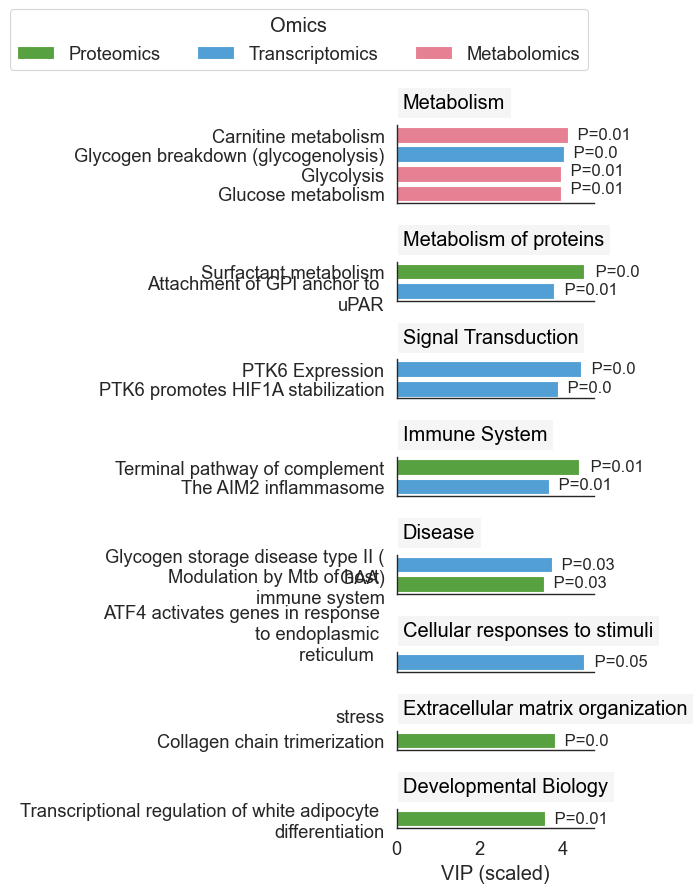

In [267]:
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
g = sns.catplot(
  kind='bar', 
  data=vips_all_sig, 
  row='Root_name', y='Name', x='VIP_scaled', orient='h',     
  hue='Source', 
  palette={'Metabolomics': sns.color_palette('husl', n_colors=3)[0], 'Proteomics': sns.color_palette('husl', n_colors=3)[1], 'Transcriptomics':sns.color_palette('husl', n_colors=3)[2]}, 
  dodge=False, 
  sharex=True, sharey=False,
  facet_kws={'gridspec_kws':{'height_ratios':[i/10 for i in  vips_all_sig['Root_name'].value_counts()] }},
  row_order=vips_all_sig['Root_name'].value_counts().index.tolist(),
  aspect=3,
  height=1,
  legend=True)

g.despine(left=False, right=True, top=True, bottom=False)
g.set_titles("{row_name}",
  fontdict={'fontsize': 12,
 'fontweight': 'light',
 'color': 'k',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'left',
#  'backgroundcolor': 'lightgrey',
 'position':[0.03, 20],
 'bbox': {'facecolor': 'whitesmoke', 'pad': 5, 'boxstyle': 'square,pad=0.3'}},
 pad=12)

annot = vips_all_sig['P-value'].tolist()
count=0
for ax in g.axes.ravel():
  for p in ax.patches:
    if not np.isnan(p.get_width()):
      ax.annotate(" P="+ str(np.round(annot[count], 2)), xy=(p.get_x() + p.get_width() , p.get_y() + p.get_height() /2),
                  textcoords='offset points', ha="left", va="center", fontsize=12)
      count +=1 

# g.set_xticklabels(rotation=90)
g.set_axis_labels("VIP (scaled)", "")
# g.title('Top 15 pathways by parent class')
sns.move_legend(g, "upper center", bbox_to_anchor=(0.0, 1.1), title='Omics', ncol=3, frameon=True)
plt.subplots_adjust(hspace=1.6, wspace=0.8)
plt.tight_layout()
plt.savefig('../Figures/COPDgene_m1_3o_GOLD_pathways_by_hieararchy.png', dpi=350, bbox_inches='tight')
plt.show()

In [86]:
vips_all[vips_all['P-value'] <= 0.05].to_csv('../COPDgene/COPDgene_3o_sig_pval.csv')

Hierarchy colourmap

In [73]:
hierarchy_cmap = pd.read_csv('D:/PathIntegrate/root_cmap.csv')

In [74]:
hierarchy_cmap['Name'] = hierarchy_cmap['Unnamed: 0'].map(dict(zip(mo_paths_all.index, mo_paths_all['Pathway_name'])))

In [75]:
hierarchy_cmap

Unnamed: 0        0                                  Name
0   R-HSA-1474244  #f77189     Extracellular matrix organization
1   R-HSA-9748784  #f77467                             Drug ADME
2   R-HSA-9709957  #f17b32                    Sensory Perception
3   R-HSA-4839726  #da8a32                Chromatin organization
4    R-HSA-400253  #c89332                       Circadian Clock
5   R-HSA-8953854  #b99932                     Metabolism of RNA
6   R-HSA-1266738  #ab9e31                 Developmental Biology
7   R-HSA-8963743  #9ba331              Digestion and absorption
8   R-HSA-1640170  #89a731                            Cell Cycle
9   R-HSA-9612973  #6ead31                             Autophagy
10   R-HSA-112316  #34b331                       Neuronal System
11   R-HSA-168256  #33b16a                         Immune System
12  R-HSA-1643685  #34b082                               Disease
13   R-HSA-397014  #35ae92                    Muscle contraction
14  R-HSA-8953897  #35ad9f         Cellular responses to stimuli
15  R-HSA-1852241  #36aca9  Organelle biogenesis and maintenance
16  R-HSA-1430728  #37abb4                            Metabolism
17  R-HSA-1474165  #38aac0                          Reproduction
18   R-HSA-392499  #39a8ce                Metabolism of proteins
19    R-HSA-73894  #3ba5e3                            DNA Repair
20  R-HSA-1500931  #5e9ef4               Cell-Cell communication
21  R-HSA-9609507  #8c94f4                  Protein localization
22   R-HSA-382551  #ab89f4          Transport of small molecules
23    R-HSA-74160  #c77df4       Gene expression (Transcription)
24    R-HSA-69306  #e36bf4                       DNA Replication
25  R-HSA-5653656  #f55fe7            Vesicle-mediated transport
26  R-HSA-5357801  #f565ce                 Programmed Cell Death
27   R-HSA-162582  #f669b9                   Signal Transduction
28   R-HSA-109582  #f66da3                            Hemostasis

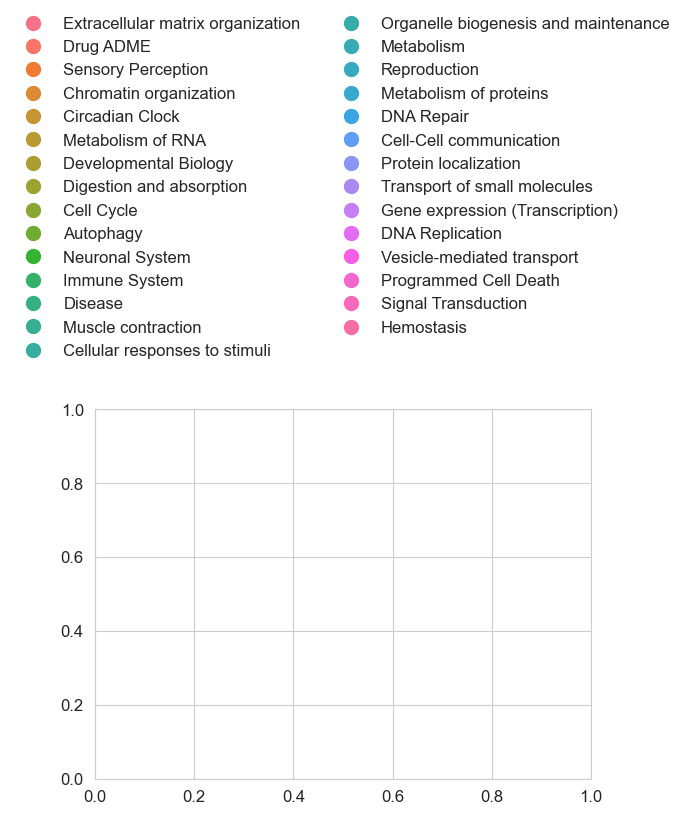

In [77]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

handles = []
names = hierarchy_cmap['Name'].to_list()
for n, i in enumerate(hierarchy_cmap['0']):
    handles.append(mlines.Line2D([], [], color=i, marker='o', linestyle='None',
                          markersize=10, label=names[n]))

plt.figure()
plt.legend(handles=handles, ncol=2, bbox_to_anchor=(0.5, 1.6), loc='center', frameon=False)
plt.savefig('../Figures/COPDgene_pathway_hierarchy_legend.png', dpi=350, bbox_inches='tight', transparent=True)
plt.show()